![](../assets/header-logo.png)

# *Enhancing Urban Driving Environment Modelling through Panoptic Segmentation with DETR: A Cityscapes Dataset Analysis*

**Automated and Connected Driving Challenges - Research Project - *09/2023***

**Research Topic *12: Panoptic Image Segmentation***

| Author | Mail |
| --- | --- |
| *Natalia Melo Fernandez* | *natalia.melo.fernandez@rwth-aachen.de* |
| *Shubhom Viresh Tenginkai* | *vtshubhom@rwth-aachen.de* |
| *Darpan Antala* | *darpankumar.antala@rwth-aachen.de* |

**Automated and Connected Driving Challenges - Research Project (Summer Term 2023)**

### Dependencies and Setup

**Execution Environment**: ADD TIME REQUIRED TO COMPUTE HARDWARE AND SETTING OF THE COMPUTER

**Dependencies**: The following dependencies are required.

In [1]:
import sys

!{sys.executable} -m pip install \
    torch==2.0.1+cu117 torchvision -f https://download.pytorch.org/whl/torch_stable.html \
    cityscapesScripts \
    git+https://github.com/cocodataset/panopticapi.git \
    pillow==8.3.2 \
    protobuf==3.20 \
    transformers==4.31.0 \
    timm==0.9.1 \
    pytorch_lightning==1.2.0 \
    tensorboard \
    openpyxl \
    torchmetrics@git+https://github.com/Lightning-AI/torchmetrics.git \
    pycocotools\
    pynvml 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/cocodataset/panopticapi.git to c:\users\vtshu\appdata\local\temp\pip-req-build-fptvmhn_
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/Lightning-AI/torchmetrics.git to c:\users\vtshu\appdata\local\temp\pip-install-devh664j\torchmetrics_c8079ddda40e48a7b83a4c592ed13a83
  Resolved https://github.com/Lightning-AI/torchmetrics.git to commit ca9fe3d5eb98615fba7031d1b9b7152a2e94af8b
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git 'C:\Users\vtshu\AppData\Local\Temp\pip-req-build-fptvmhn_'
  Running command git clone --filter=blob:none --quiet https://github.com/Lightning-AI/torchmetrics.git 'C:\Users\vtshu\AppData\Local\Temp\pip-install-devh664j\torchmetrics_c8079ddda40e48a7b83a4c592ed13a83'


In [3]:
import torch
print(torch.__version__)

import pytorch_lightning as pl

print("PyTorch Lightning version:", pl.__version__)
# !pip install torchvision --upgrade
!# pip install torch torchvision --upgrade

2.0.1+cu117
PyTorch Lightning version: 1.2.0


In [4]:
# Import python packages
import os
import zipfile
import json
import torch


#packages for data augmentations
import tensorflow as tf
import cv2
import random

from PIL import Image

import matplotlib.patches as mpatches
import matplotlib.colors as ListedColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pynvml

from panopticapi.utils import rgb2id

# Cityscapesscripts imports
from cityscapesscripts.preparation.createPanopticImgs import convert2panoptic
from cityscapesscripts.download.downloader import login, download_packages, get_available_packages, list_available_packages

# Packages required for creation of Torch Dataset
from transformers import DetrFeatureExtractor, DetrForSegmentation, DetrImageProcessor, DetrConfig
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
from torchvision import transforms
import time
from torch import nn
from torch import device, cuda
import pytorch_lightning as pl

# Packages used to check CUDA memory available
import pynvml

# Packages used for training
from pytorch_lightning import Trainer

#Packages used for evaluation
from torchmetrics import JaccardIndex
import pandas as pd
import torchmetrics
from torchmetrics.detection import PanopticQuality
import torch.nn.functional as F
import random
import sys

# Mapping required for IKA evaluation
sys.path.append("data/ika-dataset/acdc-rp_topic-01_data/acdc-rp_topic-01_data/ika-dataset")
from rgb_to_class_id import rgb_to_class_id as color_to_ika_ids

C:\Users\UX534\anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: llow is an invalid version and will not be supported in a future release
  warnings.warn(


ModuleNotFoundError: No module named 'rgb_to_class_id'

In [ ]:
sys.path.append("data/ika-dataset/acdc-rp_topic-01_data/acdc-rp_topic-01_data/ika-dataset")
from rgb_to_class_id import rgb_to_class_id as color_to_ika_ids

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
if torch.cuda.is_available():
    cuda_version = torch.version.cuda
    print(f"CUDA Version: {cuda_version}")
else:
    print("CUDA is not available on this system.")
    
print(f"PyTorch Version: {torch.__version__}")

### Required Downloads:
It is required to download the following:
- Cityscapes Dataset
- IKA Dataset
- Cityscapes Benchmark Results

#### Cityscapes Dataset
Helper functions in [Section 2.1.2](#Downloading-Cityscapes-Dataset) have been provided to automatically download the required Cityscapes dataset into the correct folder.

However, the dataset can also be set up manually by following the steps below. The download of the files takes approximately COMMENT ADD ESTIMATION.

Note that even if the the dataset has been set up manually, the cells in [Section 2.1.2](#Downloading-Cityscapes-Dataset) still need to be run, as these helper functions will be used throughout the report

1. **Create a Folder:**

   Create a new folder in the same directory as this Jupyter Notebook. Name it **dataset**

2. **Download Dataset:**

    Download **gtFine_trainvaltest.zip** and **leftImg8bit_trainvaltest.zip** from [https://www.cityscapes-dataset.com/downloads/](https://www.cityscapes-dataset.com/downloads/)

3. **Place dataset in the folder:**

   Extract the contents of the ZIP file and place them in the **dataset** folder.

4. **Confirm Directory Structure:**

   Your directory structure should now look like this:
   
   12-Panoptic-Image-Segmentation/
   
    ├── Final2.ipynb  #Comment: Change name

    ├── dataset/
    
    │ ├── gtFine_trainvaltest
    
    │ ├── leftImg8bit_trainvaltest
        
    └── ...

In [ ]:
# Helper functions to download and save the Cityscapes Dataset in the appropiate format

def create_dataset_folder(dataset_path):    
    if os.path.exists(dataset_path):
        print("Dataset folder already exists")
    
    else:
        os.makedirs(dataset_path)
        print("Dataset folder has been created successfully")
        

def download_required_datasets(dataset_gtFine_name, dataset_leftImg8_name):
    session = login()
    download_packages(session=session, package_names=['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip'], destination_path=dataset_path)

    
def unzip_dataset(dataset_path):

    for file in os.listdir(dataset_path):
        print(file)
        # Construct unzipped folder path
        zip_folder_path = os.path.join(dataset_path, file)
        output_folder_path = os.path.splitext(zip_folder_path)[0]
        
        # Extract contents of the zip file into extraction folder
        with zipfile.ZipFile(zip_folder_path, "r") as zip_ref:
            zip_ref.extractall(output_folder_path)
#idchange
def id_change(data_type):
    json_path = os.path.join('dataset','COCO_Annotated', "cityscapes_panoptic_"+data_type+"_trainId.json")
    
    with open(json_path, 'r') as f:
        annotations_json = json.load(f)
        print('loaded')
        
    for i, item in enumerate(annotations_json['annotations']):
        name = item['image_id']
        name_list = name.split('_')
        new_str = ''.join(name_list[1:3]) + str(i)
        item['image_id'] = new_str
        
        
    for i, item in enumerate(annotations_json['images']):
        name = item['id']
        name_list = name.split('_')
        new_str = ''.join(name_list[1:3]) + str(i)
        item['id'] = new_str
        
    with open(json_path, 'w') as f:
        json.dump(annotations_json, f)

In [ ]:
# Specify the name of the datasets to be downloaded
dataset_gtFine_name = 'gtFine_trainvaltest'
dataset_leftImg8_name = 'leftImg8bit_trainvaltest'

# Define the path where the datasets will be stored
dataset_path = 'dataset'

# Check if the dataset path exists; if not, proceed to create and download datasets
if not os.path.exists(dataset_path):
    create_dataset_folder(dataset_path)
    download_required_datasets(dataset_gtFine_name, dataset_leftImg8_name)
    unzip_dataset(dataset_path)

#### Cityscapes Benchmark Results
It is required to download the Cityscapes Benchmark results. Download in Excel format the results for Pixel-Level Semantic Labeling Task, Instance-Level Semantic Labeling Task and Panoptic Semantic Labeling Task. These can be accessed through the links below:
- Pixel-Level Semantic Labeling Task: https://www.cityscapes-dataset.com/benchmarks/#pixel-level-results
- Instance-Level Semantic Labeling Task: https://www.cityscapes-dataset.com/benchmarks/#instance-level-results
- Panoptic Semantic Labeling Task: https://www.cityscapes-dataset.com/benchmarks/#panoptic-results

The above files have to be stored in a new folder named 'benchmark_folder'. This can be created by running the cell below. Then upload the corresponding files with the following naming conventions:   
   12-Panoptic-Image-Segmentation/
   
    ├── Final2.ipynb  #Comment: Change name

    ├── dataset/
       
    │ ├── benchmark_folder
    
    │ │ ├── panoptic_benchmark.xlsk

    │ │ ├── semantic_benchmark.xlsk

    │ │ ├── instance_benchmark.xlsk
        
    └── ...

In [ ]:
# Create folder to store benchmark results
benchmark_folder_path = os.path.join(dataset_path, 'benchmark_folder')

if not os.path.exists(benchmark_folder_path):
    create_dataset_folder(benchmark_folder_path)

#### Download IKA Dataset

Please download the IKA dataset using the following link: https://rwth-aachen.sciebo.de/s/xkPs4OPBdtuA6YF

Position the downloaded file in the following folder: "data\ika-dataset\acdc-rp_topic-01_data" and unzip.

# **1. Abstract**

**This report details the development of a tailored panoptic segmentation pipeline suitable for training and evaluation in the cityscapes dataset. For this purpose, the pre-trained DETR model 'detr-resnet-50-panoptic' was used, sourced from Hugging Face's repository and originally tailored for the COCO dataset. The report details the refinement of this model through fine-tuning, aiming to adapt it to the unique intricacies and challenges posed by the Cityscape dataset.The proposed pipeline encapsulates diverse approaches, including full model training, freezing transformers, data augmentation and hyperparameter tuning, enabling the evaluation and comparison of these approaches.The paper concludes by evaluation, and real-world inference. The proposed pipeline undergoes rigorous assessment using well-established performance metrics, including PQ, SP, and RQ. Furthermore, we extend our evaluation to encompass instance and semantic segmentation, ensuring a comprehensive understanding of the model's effectiveness to perform these tasks. Furthermore, the pipeline's efficacy is analysed through inference on the IKA dataset, showcasing its poor generalisation capabilities.**

# **2.Introduction**

The field of computer vision has made remarkable strides in image recognition tasks, where the ultimate objective is to discern and categorize elements within an image. These elements can be broadly classified into two categories: "things" and "stuff." "Things" encompass countable objects such as vehicles, individuals, and furniture items, while "stuff" refers to uncountable regions like sky, road, and water.[[8]](https://arxiv.org/pdf/1801.00868.pdf) Several prominent tasks have emerged to identify these elements within images, including instance segmentation and semantic segmentation, each with its unique focus and limitations.

Instance segmentation aims to detect and segment individual objects or "things," providing pixel-level masks for each identified instance. Semantic segmentation, on the other hand, aims to predict class labels for each pixel in an image, encompassing both "things" and "stuff" categories.[[5]](https://arxiv.org/pdf/1703.06870.pdf) However, semantic segmentation does not differentiate between different instances of the same class, leaving room for further refinement in fully describing the image contents.

In response to this gap, the concept of panoptic segmentation has emerged as a comprehensive solution. Panoptic segmentation seeks to merge the strengths of instance and semantic segmentation by assigning each pixel a class label and an instance identifier. For "things" classes, instance identifiers distinguish between different object instances, while for "stuff" classes, a unified instance identifier is assigned due to the non-countable nature of these elements. This holistic approach to segmentation offers a more intricate and detailed understanding of visual scenes, enhancing the ability to perceive and interpret complex imagery.[[3]](https://arxiv.org/pdf/1809.02110v2.pdf)

The report introduces a pipeline methodology for extending models specifically designed and trained for solving panoptic segmentation tasks in the COCO dataset to other datasets within the domain of autonomous driving. This includes the widely known Cityscapes dataset and the customized IKA dataset.

To demonstrate the versatility and adaptability of the codebase, the same methodology and functions were applied to another dataset, showcasing its effectiveness and flexibility beyond the original dataset context. This multi-faceted approach not only extends the applicability of panoptic segmentation but also underscores the practicality and significance of our research in advancing the field of computer vision and autonomous driving.

In addition, the report presents a valuable contribution to segmentation evaluation methodologies, comprising of:

Functions that facilitate the extraction of both semantic and instance segmentation information from panoptic segmentation results and their visualization. 

Extending existing Panoptic Segmentation and Semantic Segmentation measures that compute averaged performance measures to assess, in addition, class-wise performance. These functions offer profound insights into the quality and effectiveness of the segmentation, including the existence of any biases in the model’s prediction or the presence of class imbalance issues, enhancing our ability to scrutinize and improve segmentation outcomes. In addition, a concise and clear methology to extrapolate the pipeline to other datasets, such as the IKA dataset.

Furthermore, this report sheds light on recent research endeavors that have paved the way for efficient and accurate panoptic segmentation. One such remarkable approach involves the adoption of transformers, a popular architecture for sequence prediction, to directly predict sets of objects within an image. The report presents an in-depth exploration of the DEtection TRansformer (DETR), a model that streamlines the object detection pipeline and simplifies traditional hand-designed components.[[1]](https://arxiv.org/pdf/2005.12872.pdf)

This report encompasses an exploration of various training strategies, encompassing approaches such as freezing the transformer, standard fine-tuning, and training with data augmentation. Additionally, it delves into the impact of data augmentation on model performance, drawing comparisons between scenarios with and without data augmentation.

To validate and assess the results comprehensively, we are conducting a comparative analysis across various factors, including different loss functions, GPU memory utilization, and overall runtime, for each of these approaches. This multifaceted evaluation allows us to gain understanding of the strengths and weaknesses of each training strategy.

# **3.Related Work**

This section provides a survey of relevant research and approaches related to panoptic segmentation, highlighting the evolution of techniques, architectures, and datasets.

**Instance and Semantic Segmentation:**
Instance segmentation [[4]](https://arxiv.org/ftp/arxiv/papers/2111/2111.10250.pdf) entails the simultaneous identification and pixel-level delineation of individual object instances within an image. Semantic segmentation [[4]](https://arxiv.org/ftp/arxiv/papers/2111/2111.10250.pdf), in contrast, aims to label each pixel with a class category, offering a comprehensive understanding of object distributions. While both tasks have been pivotal in advancing scene understanding, they do not provide a unified representation that encapsulates both "things" and "stuff" categories. Panoptic segmentation addresses this gap by harmonizing instance and semantic segmentation, thus yielding a richer depiction of scenes.

**various methods to achieve panoptic**
A detailed review on the different approaches to perform panoptic was presented in  Omar [[4]](https://arxiv.org/ftp/arxiv/papers/2111/2111.10250.pdf). They mentioned four different methodologies for panoptic segmentation: Sharing backbone, Explicit connections, one shot model and cascade model. As one shot method has one single network to perform panoptic, its considered to be more efficient in terms of the model size and training time to achieve comparable performance[[4]](https://arxiv.org/ftp/arxiv/papers/2111/2111.10250.pdf). Since the task of autonomous driving emphasis on efficiency of the model for real time computaion we decided to proceed with one shot model for our implementation.

**Various One-shot models**
Some of the popular models that exist currently are Panoptic FCN[[18]](https://arxiv.org/pdf/2012.00720.pdf), Maskformer[[16]](https://arxiv.org/pdf/2107.06278.pdf), Mask2former[[17]](https://arxiv.org/pdf/2112.01527.pdf),Detr[[1]](https://arxiv.org/pdf/2005.12872.pdf) etc. One common pattern that can be noted is the use of transformer architecture in most of the above-mentioned models. With the rise of transformer in the computer vision domain its use in our implementation became evident. This narrowed down our list by three model: Maskformer, Mask2former and Detr. All three approaches use mask classification model to set of binary masks belonging to different class. The previous approaches relied on pixel-wise classification. This sets them apart from the rest. This also lets them solve both semantic and instance segmentation using a unified model with common loss and training procedures. Detr was chosen among the three due to its simple architecture and its straightforward approach towards panoptic segmentation. The resource availability among the various models also played a crucial role. Additionally, Detr had comparable performance with respect to maskformer and mask2former.



DETR
DEtection TRansformer was among the first models that employed a transformer based approach. The aim of the model to decrease the reliance on several post-processing techniques which are hand-designed components like non-maximum suppression, thresholding, spatial anchor etc. Here the model uses loss based on Hungarian algorithm to find a bipartite matching between the ground truth and predictions. This guarantees a unique match for each target. The Detr model is simple when compared to the other choices. It has three components, CNN backbone, an encoder decoder transformer and a simple Feed Forward network to make the Bounding box predictions. An additional Mask head is used to extend the results for a panoptic output.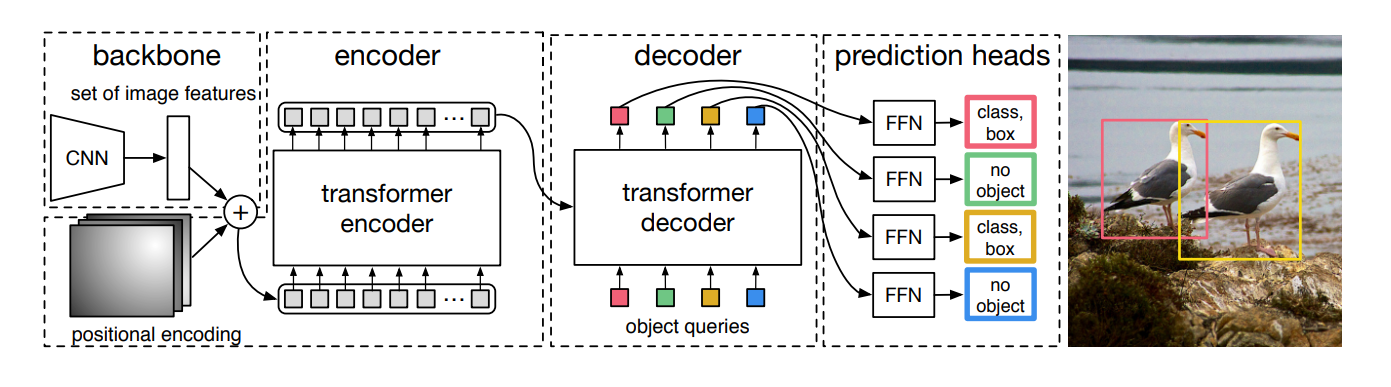

The Backbone is used for feature extraction wherein a lower-resolution feature map is generated for further processing. This is passed on to the transformer encoder wherein The output is further reduced to a lower resolution and then is collapsed into a sequence inputs. Then the inputs are supplemented with positional information and are passed on to self attention module and FFN module. Later these inputs are passed on to decoder wherein N object queries are transformed into an output embedddings. The feed fornwrd network of the decoder transforms them into box coordinated along with the respective class labels. Finally the box embeddings are taken in by the mask head and transformed into mask logits as shown in image.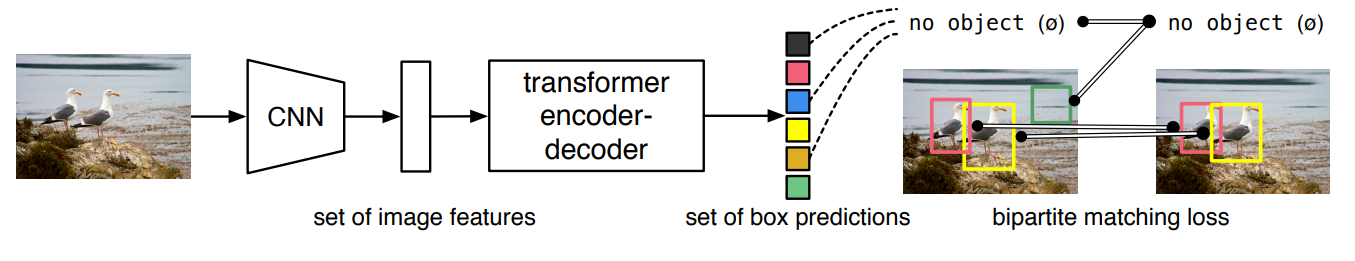

**Other models**
Early approaches in panoptic segmentation involved post-processing methods, such as merging instance and semantic segmentation outputs using heuristics [[4]](https://arxiv.org/ftp/arxiv/papers/2111/2111.10250.pdf). Researchers have also investigated methods that combine pre-trained models for detecting individual objects and labeling image regions, resulting in impressive achievements in panoptic segmentation. One recent advancement involves the use of special networks [[2]](https://arxiv.org/pdf/1901.02446v2.pdf) that bring together information about both individual objects and overall scene context to create more detailed panoptic segmentations. Additionally, tools like Mask R-CNN [[5]](https://arxiv.org/pdf/1703.06870.pdf) have been expanded to handle panoptic segmentation tasks, joining the dots between recognizing specific objects and understanding the broader scene.

**Applications and Beyond:**
The significance of panoptic segmentation extends beyond its role as an intermediate step in scene understanding. Applications span various domains, including autonomous driving, robotics, and augmented reality. By providing a comprehensive scene representation, panoptic segmentation enables more sophisticated decision-making processes and interaction with the environment, driving advancements in multiple real-world scenarios.

**Datasets and Benchmarks:**
To benchmark panoptic segmentation methods, researchers have relied on established datasets. Cityscapes is a widely used dataset for urban scene understanding, providing pixel-level annotations for both things and stuff categories. COCO is another prominent dataset that includes object instances and semantic labels, facilitating evaluations of panoptic segmentation techniques. As panoptic segmentation gains momentum, efforts to curate larger and more diverse datasets, such as ADE20K and Mapillary Vistas, have emerged to enable more comprehensive evaluations and advancements.

In summary, panoptic segmentation is a dynamic field that amalgamates insights from instance and semantic segmentation, offering a more holistic understanding of visual scenes. The evolution of approaches, architectures, and datasets continues to propel panoptic segmentation towards enhancing scene analysis and facilitating applications across diverse domains.


# **4. Methodology**
The methodology employed in the implementation of the panoptic segmentation pipeline involves a systematic approach to data preprocessing, model selection, training, and evaluation. The pipeline is designed to seamlessly integrate various components, ensuring the generation of accurate and comprehensive panoptic segmentations. The following subsections outline the key steps undertaken in the construction and execution of the panoptic segmentation pipeline.

## **Cityscapes Dataset for Panoptic Segmentation in Autonomous Vehicles**

The selection of an appropriate dataset plays a pivotal role in the development and evaluation of panoptic segmentation models, particularly within the domain of autonomous vehicles.Among the top datasets available for this purpose, three prominent options stand out: Cityscapes, ApolloScape, and Waymo Open Dataset.

**Cityscapes:**
Cityscapes is a widely recognized dataset specifically designed for urban scene understanding. It comprises high-quality, high-resolution images captured in real-world urban environments. The dataset contains diverse scenarios, including various lighting conditions, weather, and traffic situations. Cityscapes offers both fine-grained instance annotations and semantic segmentation labels, making it suitable for panoptic segmentation development. Its focus on urban environments aligns well with the challenges faced by autonomous vehicles in navigating complex cityscapes, making it a valuable dataset for model training and evaluation.[[6]](https://github.com/mcordts/cityscapesScripts)

**ApolloScape:**
ApolloScape focuses on providing a comprehensive dataset for autonomous driving research. It features a rich collection of data, including images, LiDAR point clouds, and HD maps. The dataset encompasses various scenarios such as urban, suburban, and highway driving, allowing researchers to explore different driving contexts.

**Waymo Open Dataset:**
Developed by Waymo, this dataset offers an extensive collection of high-resolution sensor data, including LiDAR and camera data. It covers a wide range of environments and scenarios, providing valuable information for perception and motion planning tasks in autonomous driving.

Among the available options, the Cityscapes dataset emerges as a compelling choice due to its unique attributes and relevance to the challenges encountered in urban environments. This section elucidates the reasons behind the preference for the Cityscapes dataset over other alternatives for the purpose of panoptic segmentation in autonomous vehicles.

**1. Realistic Urban Scenarios:**

Cityscapes is meticulously curated to encapsulate the complexities of real-world urban scenes, making it an ideal dataset for simulating the intricacies of autonomous driving environments. The dataset comprises high-resolution images captured across diverse urban settings, encompassing a wide spectrum of scenarios that autonomous vehicles are likely to encounter. This realism ensures that panoptic segmentation models trained on Cityscapes are well-equipped to handle the nuances of urban landscapes, including varied lighting conditions, road geometries, and pedestrian interactions.

**2. Rich Panoptic Segmentation Annotations:**

Cityscapes offers comprehensive panoptic segmentation annotations. The level of detail displayed in the annotations facilitates the training of panoptic segmentation models to distinguish between various object instances, enabling the precise identification of individual vehicles, pedestrians, and other relevant entities on the road.

**3. Real-World Relevance:**

The Cityscapes dataset reflects the intricacies and complexities of urban driving scenarios, aligning with the real-world challenges faced by autonomous vehicles. This realism enhances the generalization capabilities of panoptic segmentation models to handle diverse and dynamic road conditions, thereby contributing to the development of safer and more reliable autonomous driving systems.

**4. Benchmarking and Evaluation:**

Cityscapes provides a well-established benchmark for evaluating the performance of panoptic segmentation models in autonomous vehicle contexts. The dataset's extensive evaluation metrics, including Panoptic Quality (PQ) and Intersection over Union (IoU), offer a standardized framework to assess the accuracy and effectiveness of panoptic segmentations. This benchmarking process aids in identifying model strengths, weaknesses, and areas for improvement, fostering the advancement of panoptic segmentation techniques tailored to autonomous driving.

In conclusion, the Cityscapes dataset stands out as a preferred choice for panoptic segmentation in the context of autonomous vehicles. Its fidelity to real-world urban scenarios, rich annotations, alignment with panoptic segmentation challenges, and robust benchmarking capabilities make it a valuable resource for training and evaluating panoptic segmentation models that cater specifically to the intricate demands of autonomous driving environments.

In [ ]:
# Helper functions to download and save the Cityscapes Dataset in the appropiate format

def create_dataset_folder(dataset_path):    
    if os.path.exists(dataset_path):
        print("Dataset folder already exists")
    
    else:
        os.makedirs(dataset_path)
        print("Dataset folder has been created successfully")
        

def download_required_datasets(dataset_gtFine_name, dataset_leftImg8_name):
    session = login()
    download_packages(session=session, package_names=['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip'], destination_path=dataset_path)

    
def unzip_dataset(dataset_path):

    for file in os.listdir(dataset_path):
        print(file)
        # Construct unzipped folder path
        zip_folder_path = os.path.join(dataset_path, file)
        output_folder_path = os.path.splitext(zip_folder_path)[0]
        
        # Extract contents of the zip file into extraction folder
        with zipfile.ZipFile(zip_folder_path, "r") as zip_ref:
            zip_ref.extractall(output_folder_path)
#idchange
def id_change(data_type):
    json_path = os.path.join('dataset','COCO_Annotated', "cityscapes_panoptic_"+data_type+"_trainId.json")
    
    with open(json_path, 'r') as f:
        annotations_json = json.load(f)
        print('loaded')
        
    for i, item in enumerate(annotations_json['annotations']):
        name = item['image_id']
        name_list = name.split('_')
        new_str = ''.join(name_list[1:3]) + str(i)
        item['image_id'] = new_str
        
        
    for i, item in enumerate(annotations_json['images']):
        name = item['id']
        name_list = name.split('_')
        new_str = ''.join(name_list[1:3]) + str(i)
        item['id'] = new_str
        
    with open(json_path, 'w') as f:
        json.dump(annotations_json, f)

In [ ]:
# Specify the name of the datasets to be downloaded
dataset_gtFine_name = 'gtFine_trainvaltest'
dataset_leftImg8_name = 'leftImg8bit_trainvaltest'

# Define the path where the datasets will be stored
dataset_path = 'dataset'

# Check if the dataset path exists; if not, proceed to create and download datasets
if not os.path.exists(dataset_path):
    create_dataset_folder(dataset_path)
    download_required_datasets(dataset_gtFine_name, dataset_leftImg8_name)
    unzip_dataset(dataset_path)

# Image Preprocessing
The selected DETR model requires the utilization of labels adhering to the COCO format. Therefore, as a preliminary step, it is required to convert the panoptic label structure, inherent to the Cityscapes dataset, into the COCO-compliant format.

In [ ]:
# Set path to convert Cityscapes Panoptic Dataset to COCO
cityscapes_annotations_path = os.path.join(dataset_path, dataset_gtFine_name, 'gtFine')

# Set path to output annotated COCO dataset
COCO_annotations_path = os.path.join(dataset_path, 'COCO_Annotated')

if not os.path.exists(COCO_annotations_path):
    create_dataset_folder(COCO_annotations_path)
    convert2panoptic(cityscapes_annotations_path , COCO_annotations_path, useTrainId=True)
    #change image id 
    id_change('train')
    id_change('test')
    id_change('val')


## Semantic Label Mapping and Categorization
This section outlines essential mappings and categorizations applied to the label data, primarily facilitating the conversion from the Cityscapes dataset format to the COCO format for compatibility with the chosen DETR model. The relationships between class identifiers for both formats, semantic categories, related visualisation colours, stuff/thing identifiers are provided to ensure a comprehensive understanding and visualisation of the labels and its implications for subsequent evaluation and analysis.

In [ ]:
## Define relation between class id and colour
rgb_to_class_id = {
    0: [0,  0,  0],
    1: [255,  255,  0],
    2: [0,  255,  0],
    3: [0,  0,  255],
    4: [90, 100,  200],
    5: [111, 74,  0],
    6: [81,  0, 81],
    7: [128, 64,128],
    8: [244, 35,232],
    9: [250,170,160],
    10: [230,150,140],
    11: [70, 70, 70],
    12: [102,102,156],
    13: [190,153,153],
    14: [180,165,180],
    15: [150,100,100],
    16: [50,120, 90],
    17: [153,153,153],
    18: [153,153,153],
    19: [250,170, 30],
    20: [220,220,  0],
    21: [107, 142, 35],
    22: [152, 251, 152],
    23: [70, 130, 180],
    24: [220, 20, 60],
    25: [255, 0, 0],
    26: [0, 0, 142],
    27: [0, 0, 70],
    28: [0, 60,100],
    29: [0, 0, 90],
    30: [0, 0, 110],
    31: [0, 80, 100],
    32: [0, 0, 230],
    33: [119, 11, 32],
    34: [0, 0, 142]
}

categories = {
    0: 'unlabeled',
    1: 'ego vehicle',
    2: 'rectification border',
    3: 'out of roi',
    4: 'static',
    5: 'dynamic',
    6: 'ground',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'caravan',
    30: 'trailer',
    31: 'train',
    32: 'motorcycle',
    33: 'bycicle',
    34: 'license plate'
}

label2id = {value: key for key, value in categories.items()}

category_id_things = [6, 7]

category_id = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 1,
    8: 1,
    9: 1,
    10: 1,
    11: 2,
    12: 2,
    13: 2,
    14: 2,
    15: 2,
    16: 2,
    17: 3,
    18: 3,
    19: 3,
    20: 3,
    21: 4,
    22: 4,
    23: 5,
    24: 6,
    25: 6,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7,
    31: 7,
    32: 7,
    33: 7,
    34: 8,
}

label_ids_to_fuse = {
0., #(road)
1., #(sidewalk)
2., #(building)
3., # (wall)
4., # (fence)
5., #(pole)
6., # (traffic light)
7., # (traffic sign)
8., # (static)
9., # (terrain)
10., # (sky)
19., # (unlabeled)
20., # (dynamic)
21., #(ground)
22., # (static)
23., # (vegetation)
24., # (rail track)
34., # (license plate)
}



is_thing_class = {
    0: False,
    1: False,
    2: False,
    3: False,
    4: False,
    5: False,
    6: False,
    7: False,
    8: False,
    9: False,
    10: False,
    11: False,
    12: False,
    13: False,
    14: False,
    15: False,
    16: False,
    17: False,
    18: False,
    19: False,
    20: False,
    21: False,
    22: False,
    23: False,
    24: True,
    25: True,
    26: True,
    27: True,
    28: True,
    29: True,
    30: True,
    31: True,
    32: True,
    33: True,
    34: False,
}

coco_to_cityscapes_class_id = {
0: 7, #(road)
1: 8, #(sidewalk)
2: 11, #(building)
3: 12, # (wall)
4: 13, # (fence)
5: 17, #(pole)
6: 19, # (traffic light)
7: 20, # (traffic sign)
8: 21, # (static)
9: 22, # (terrain)
10: 23, # (sky)
11: 24, # (person)
12: 25, # (rider)
13: 26, # (car)
14: 27, #(truck)
15: 28, # (bus)
16: 31, # (train)
17: 32, #(motorcycle)
18: 33, # (bicycle)
19: 0, # (unlabeled)
20: 1, # (dynamic)
21: 2, #(ground)
22: 3, # (static)
23: 4, # (vegetation)
24: 5, # (rail track)
34: 34, # (license plate)

}

## Additional mappings used for evaluation. Convert previous dictionaries into sets.
things_ids = set()
label_ids_to_fuse_set = set()

for key, value in is_thing_class.items():
    if value:
        things_ids.add(key)
    else:
        label_ids_to_fuse_set.add(key)

# Data Augmentation
The Dataset created is increased in size using Data augmentation techniques. There are two important types of data augmentation. the first one is geometric augmentation which involves operations such as flipping, shearing, rotations, cropping, etc. These change the geometric parameters of the image. The other type is color space augmentations. This involves operations that change saturation, contrast, image quality, etc. These changes do not change any geometric parameters. Nevertheless, this type of augmentation is important since needs to be robust to variations in lighting conditions, color balance, and color distortions in real-world images. This is crucial for models that need to perform well under diverse and unpredictable environmental conditions.

In our implementation we decided to apply color space augmentation. The main reason for choosing this augmentation is ability to retain the labels of the corresponding images that are augmented. When an original image is augmented to produce N (Increase Ratio) additional augmented images, the labels corresponding to the original image are retained and are additionally mapped to the augmented images. This could be seen in the json file that contains the mapping of the images and labels via imageIDs There is no need for a new label for the augmented images. This is because the color space augmentation does not change any parameters with regards to the geometry of the image hence saving the need for additional pre-processing. Labels have to modified only if there is a change in the geometric parameters of the image.

We have implemented 4 type of augmentation which are brightness, Saturation, Contrast, pixel quality. In order to maintain a good probabilistic policy in augmentation, The amount of change in brightness, saturation, contrast and pixel quality is kept random. Additional randomness is introduced in the number of augmentation that is applied to the image. This adds sufficient randomness to the augmented image introducing diversity in the dataset making the model more robust to different possibilities and hence improving the results further.

In [ ]:
def aug_flow(img,increase_ratio):
    data = []
    num_images = increase_ratio  
    
    for j in range(num_images): 
        #print('printing j')
        #print(j)
        num_aug = random.randint(2,4)
        #print(num_aug)
        list_aug = [random.randint(1, 4) for _ in range(num_aug)]
        #print(list_aug)
        
        for value in list_aug:
            if value == 1:
                img = tf.image.random_brightness(img, max_delta=0.02)
            elif value == 2:
                img = tf.image.random_contrast(img, lower=0.6, upper=1)
            elif value == 3:
                img = tf.image.random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100)
            elif value == 4:
                img = tf.image.random_saturation(img, lower=0.9,upper=1)
            else:
                print("Invalid option. Please choose a value between 1 and 4.")
                
        data.append(img)
    return data
    
def append_to_json_file(file_path,custon_name, num):
    try:
        # Read the existing JSON data from the file
        with open(file_path, 'r') as file:
            annotations_json = json.load(file)
            image_dict = annotations_json['images']
            new_file_name = custon_name
            old_height = image_dict[num]['height']
            old_width = image_dict[num]['width']
            old_id = image_dict[num]['id']
            new_addition = {"file_name": new_file_name, "height": old_height, "id": old_id, "width": old_width}
            
    except FileNotFoundError:
        # If the file doesn't exist yet, initialize with an empty list
        print('file is empty')
        

    # Append the new data to the existing JSON data
    annotations_json['images'].append(new_addition)

    # Write the updated JSON data back to the file
    with open(file_path, 'w') as file:
        json.dump(annotations_json, file)
        


In [ ]:
#path to the training dataset and its json file
file_path = r'dataset\leftImg8bit_trainvaltest\leftImg8bit\train' 
json_train_path = os.path.join('dataset','COCO_Annotated', "cityscapes_panoptic_train_trainId.json")
increase_ratio = 2

with open(json_train_path, 'r') as f:
    annotations_json = json.load(f)

def aug_loop(aug_needed,annotations_json,json_train_path,file_path,increase_ratio):
    if aug_needed:
        for folder in os.listdir(file_path):
            print(folder)
            new_folder = os.path.join(file_path,folder+'Aug')
            if not os.path.exists(new_folder):
                os.mkdir(new_folder)
            output_directory = os.path.join(file_path,folder+'Aug')
            for num, file in enumerate(os.listdir(os.path.join(file_path,folder))):  
                img = cv2.imread(os.path.join(file_path,folder,file))
                aug_images = aug_flow(img,increase_ratio)
                for idx, aug_img in enumerate(aug_images):
                    name_list = file.split('_')
                    custom_name = file.replace('.png',"") +'_'+str(idx)+'.png'
                    custom_name = custom_name.replace(name_list[0],name_list[0]+'Aug')
                    print(custom_name)
                    output_path = os.path.join(output_directory, custom_name)
                    bgr = cv2.cvtColor(aug_img.numpy(), cv2.COLOR_BGR2RGB)
                    cv2.imwrite(output_path, bgr)
                    append_to_json_file(json_train_path, custom_name,num)     


            
aug_loop(False,annotations_json,json_train_path,file_path,increase_ratio)

In [ ]:
os.listdir(file_path)

# Define Torch Dataset

In [ ]:
## Function to create dataset to run the detr model
class PanopticDataset(Dataset):
    '''
    Custom dataset class for handling panoptic images and annotations.


    Attributes:
        annotations_json (dict): A dictionary containing annotations in COCO format.
        dataset_path (str): Path to the root directory of the Cityscapes dataset.
        COCO_annotations_path (str): Path to the COCO-formatted annotations directory.
        feature_extractor: An instance of a DETR feature extraction model.
        set_type (str): Indicates whether the dataset is for training, validation, or testing.
    '''
    
    
    def __init__(self, annotations_json, dataset_path, COCO_annotations_path,feature_extractor, set_type):
        self.annotations_json = annotations_json
        self.dataset_path = dataset_path
        self.COCO_annotations_path = COCO_annotations_path 
        self.feature_extractor = feature_extractor
        self.set_type = set_type
        
    def __len__(self):
        """
        Returns the number of images in the dataset.

        Returns:
            (int) Number of images in the dataset.
        """
        
        return len(self.annotations_json['images'])
    
    def __getitem__(self,index):
        """
        Retrieves the processed image values and the associated panoptic IDs map of the label for an image at a given index.

        Args:
            index (int): Index of the image to retrieve.

        Returns:
            tuple: A tuple containing the processed image value and corresponding panoptic IDs map.
        """

        image_anotations = self.annotations_json['images'][index]
        image_data, panoptic_ids = self.extract_ids_from_image(image_anotations)
        return image_data, panoptic_ids
    
    def extract_ids_from_image(self, image_data):
        segmentation_data = next(seg for seg in self.annotations_json['annotations'] if seg['image_id'] == image_data['id'])
        
        image_path = os.path.join(self.dataset_path, 'leftImg8bit_trainvaltest', 'leftImg8bit' ,str(self.set_type), image_data['file_name'].split('_')[0] ,image_data['file_name'].replace('_gtFine', ""))
        segmentation_data_path = os.path.join(self.COCO_annotations_path,'cityscapes_panoptic_'+str(self.set_type)+'_trainId', segmentation_data['file_name'])

        # Load the image and the panoptic segmentation
        panoptic_seg = np.array(Image.open(segmentation_data_path))                
        panoptic_seg_ids = rgb2id(panoptic_seg)     

        
        img = Image.open(image_path).convert('RGB')
        ann_folder = os.path.join(self.COCO_annotations_path,'cityscapes_panoptic_'+str(self.set_type)+'_trainId')

        ## Requirement for test dataset, as it does not contain any labels.
        if not np.any(panoptic_seg):
            encoding = self.feature_extractor(images=img,padding=True, return_tensors="pt")
            target = []
        
        else:
            encoding = self.feature_extractor(images=img, annotations=segmentation_data, masks_path=ann_folder,padding=True, return_tensors="pt")
            target = encoding["labels"][0]

        pixel_values = encoding["pixel_values"].squeeze()

        return pixel_values, target

In [ ]:
# # Load the COCO annotations for training
json_train_path = os.path.join(COCO_annotations_path, "cityscapes_panoptic_train_trainId.json")
json_val_path = os.path.join(COCO_annotations_path, "cityscapes_panoptic_val_trainId.json")
json_test_path = os.path.join(COCO_annotations_path, "cityscapes_panoptic_test_trainId.json")

with open(json_train_path, 'r') as f:
    annotations_json_train = json.load(f)
    
with open(json_val_path, 'r') as f:
    annotations_json_val = json.load(f)
    
with open(json_test_path, 'r') as f:
    annotations_json_test = json.load(f)

## Hyperparameter Definition

The successful training and optimization of a panoptic segmentation model heavily rely on a well-tailored set of hyperparameters. In an effort to streamline the experimentation process and facilitate easy parameter tuning, all relevant hyperparameters have been grouped into a single dictionary named 'hyperparameters.' This centralized approach not only enhances the organization of our training configuration but also simplifies the process of modifying and optimizing these parameters.

In the following section, the rationale behind the chosen hyperparameters and their significance in shaping the training dynamics and overall performance of the model is presented.

**1. Dataset Size and Split:**
The `dataset_size` hyperparameter defines the total number of samples in the dataset, while the `train_percent`, `test_percent`, and `val_percent` hyperparameters determine the proportions of data allocated for training, testing, and validation, respectively. These hyperparameters collectively facilitate an effective division of the dataset, enabling comprehensive training, rigorous testing, and fine-tuned validation to ensure optimal model performance.

**2. Image Size and Scaling:**
The `image_size` hyperparameter specifies the target dimensions for resizing input images. Additionally, the `max_image_size` hyperparameter caps the maximum allowable image dimensions. Properly setting these parameters ensures that the model can handle various image resolutions encountered during inference, enhancing its adaptability to different scenarios.

**3. Learning Rates and Optimization:**
The `learning_rate` and `learning_rate_backbone` hyperparameters dictate the step sizes taken during the model's weight updates and the backbone network's weight updates, respectively. These values determine the speed and stability of the learning process. The `optimizer` hyperparameter, set to 'adam', represents the optimization algorithm employed to minimize the loss function. The `weight_decay` hyperparameter introduces regularization to prevent overfitting by penalizing large weight magnitudes.

This configuration carefully selects each hyperparameter to create a balance between model expressiveness, convergence stability, and generalization potential. Iterative experimentation and validation are used in the tuning of these hyperparameters to find the best values that produce the greatest model performance for the given panoptic segmentation job. By fine-tuning these hyperparameters, the model is able to strike a careful balance between capturing complex details and avoiding noise, resulting in precise and reliable panoptic segmentations.

In practice, optimizing these hyperparameters necessitates a thorough analysis of their impacts on model generalization, training convergence, and inference effectiveness. The subtleties of the model's response to these settings can be discovered by painstakingly experimenting with various combinations and values.

As an illustration, in our instance, we started by testing different learning rates, including 10-4, 10-3, and 10-5, for both the primary learning rate and the supporting learning rate. Through these tests, we were able to pinpoint the combination that produced the best outcomes while balancing training loss convergence and segmentation quality.

For example, changing the 'learning_rate' could affect the rate of convergence and the possibility of overshooting the ideal solutions. The model's capacity to adapt to different picture resolutions can also be affected by changes to the parameters "image_size" and "max_image_size," which may have an impact on both accuracy and inference speed.

Additionally, the model's sensitivity to overfitting and capacity to generalize to unobserved data can be strongly impacted by the choice of "optimizer" and the level of "weight_decay" regularization.

In conclusion, while the explanations of the offered hyperparameters are helpful recommendations, the real strength resides in the careful examination of their impacts on your particular panoptic segmentation work. You can identify the ideal hyperparameter combinations that result in the most precise, effective, and reliable model performance through careful experimentation and validation.


In [ ]:
hyperparameters = {
    'train_dataset_size':10,
    'test_dataset_size':4,
    'val_dataset_size':10, 
    'image_size':400,
    'longest_edge':400,
    'learning_rate': 1e-4,
    'learning_rate_backbone': 1e-4,
    'num_epochs': 50,
    'train_batch_size': 4,
    'test_batch_size': 1,
    'val_batch_size': 1,
    'hidden_units': [128, 64],
    'dropout_rate': 0.2,
    'optimizer': 'adam',
    'weight_decay':1e-4,
    'gradient_clip_val': 0.1    
}


## Dataset Preparation and Train/Test/Train Split

We begin by splitting our dataset into the following subsets:

- Training Set: This subset contains a portion of the dataset that will be used for model training. The model learns from this data to improve its segmentation performance.

- Validation Set: The validation set is used to fine-tune the model during training and to tune hyperparameters. It provides a means to monitor the model's performance on unseen data and helps prevent overfitting.

- Test Set: The test set is kept completely separate from the training and validation sets. It serves as an unbiased evaluation of the model's generalization ability on previously unseen data. The test set provided by Cityscapes does not contain panoptic segmentation labels. Therefore, it is only used for qualitative analysis of the results

In [ ]:
# we reduce the size and max_size to be able to fit the batches in GPU memory

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic", size=hyperparameters['image_size'], longest_edge=hyperparameters['longest_edge'])

train_dataset_full = PanopticDataset(annotations_json_train, dataset_path, COCO_annotations_path,feature_extractor, set_type='train')
val_dataset_full = PanopticDataset(annotations_json_val, dataset_path, COCO_annotations_path,feature_extractor, set_type='val')
test_dataset_full = PanopticDataset(annotations_json_test, dataset_path, COCO_annotations_path,feature_extractor, set_type='test')

# let's split it up into very tiny training and validation sets using random indices
np.random.seed(56)

train_indices = np.random.randint(low=0, high=len(train_dataset_full), size=hyperparameters['train_dataset_size'])
test_indices = np.random.randint(low=0, high=len(test_dataset_full), size=hyperparameters['test_dataset_size'])
val_indices = np.random.randint(low=0, high=len(val_dataset_full), size=hyperparameters['val_dataset_size'])
train_dataset = torch.utils.data.Subset(train_dataset_full, train_indices[:1400])
val_dataset = torch.utils.data.Subset(val_dataset_full, val_indices[0:50])
test_dataset = torch.utils.data.Subset(test_dataset_full, test_indices[0:50])


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

Split into training, validation and test.
Create Dataloader so that we are able to work on batches

In [ ]:
from torch.utils.data import DataLoader

def min_max_normalization(pixel_values):
    pixel_values_normalized = []
    for pixel_value in pixel_values:
        pixel_values_normalized.append((pixel_value - torch.min(pixel_value))/(torch.max(pixel_value) - torch.min(pixel_value)))
    return pixel_values_normalized

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    pixel_values_normalized = min_max_normalization(pixel_values)
    
    encoded_input = feature_extractor.preprocess(pixel_values_normalized, do_pad=True, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoded_input['pixel_values']
    batch['pixel_mask'] = encoded_input['pixel_mask']
    batch['labels'] = labels
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=hyperparameters['train_batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=hyperparameters['val_batch_size'])
test_dataloader = DataLoader(test_dataset, batch_size=hyperparameters['test_batch_size'], collate_fn = collate_fn,shuffle=True)

## Segmentation Visualization

In this section, we demonstrate the visualization of different types of segmentation for an example image from the dataset.

### Auxiliary functions for visualisation of labels
The code below defines a set of functions designed to manage and process panoptic segmentation data for analysis and visualization. These functions collectively facilitate the conversion of raw panoptic segmentation data into semantic segmentation, generate instance-level masks based on specified segmentation types, and offer visualization capabilities to aid in understanding the results. Visual inspection is utilised to ensure a correct conversion of panoptic labels into semantic and instance labels. Additionally, the code includes functions for generating similar RGB colors with controlled variations for the purpose of visualizing different instances of the same class.

In [ ]:
def mapping_semantic_segmentation(semantic_seg):
    '''
    The above function extracts the semantic labels from a panoptic segmentation map.
    
    Parameters:
        panoptic_seg: A NumPy array representing the panoptic segmentation map.
    
    Returns:
        semantic_seg: A NumPy array containing the extracted semantic segmentation map.     
    '''
    
    semantic_seg_copy = np.copy(semantic_seg)
    semantic_seg_copy[semantic_seg_copy > 1000.] = semantic_seg_copy[semantic_seg_copy > 1000.] // 1000.
    return semantic_seg_copy

def extract_ids_from_dictionary(dictionary):
    '''
    This function extracts panoptic segmentation IDs from a dictionary containing relevant annotation data.
    
    Parameters:
        dictionary: A dictionary containing masks, image size, boxes, and class labels.

    Returns:
        panoptic_seg: A NumPy array representing the panoptic segmentation map.
        
    Description:
    The function extracts masks, image size, boxes, and class labels from the input dictionary. It then constructs a panoptic segmentation map by associating masks 
    with the appropriate class labels, considering instance-specific labeling.
    '''
    
    masks = dictionary['masks']
    image_size = tuple(dictionary['size'].numpy())
    
    boxes = dictionary['boxes']
    class_labels = dictionary['class_labels']

    panoptic_seg = torch.zeros(image_size, dtype=int)
    
    class_instance_counter = {24: 0, 25: 0, 26: 0, 27: 0, 28: 0,
                              29: 0, 30: 0, 31: 0, 32: 0, 33: 0}
    
    for i in range(masks.shape[0]):
        mask = masks[i,:,:]
        box = boxes[i,:]
        class_label = coco_to_cityscapes_class_id.get(int(class_labels[i]))
        x_center, y_center, width, height = torch.mul(box, dictionary['size'].repeat(2)).int()

        if is_thing_class.get(class_label):
            class_instance_counter[class_label] += 1
            
            class_label = class_label * 1000 + class_instance_counter[class_label]
            
        binary_mask = mask.squeeze().numpy()
        panoptic_seg[binary_mask] = class_label

    return panoptic_seg


def visualize_segmentation(panoptic_dictionary, segmentation_type, categories, rgb_to_class_id, name_image='Visualisation'):
    
    #Compute and visualize different types of segmentation based on the given panoptic dictionary.
    
    # This code is duplicated with extract_ids_outputs - put into a single function
    if type(panoptic_dictionary) != np.ndarray:
        panoptic_dict = {}
        panoptic_dict['masks'] = panoptic_dictionary.masks
        panoptic_dict['boxes'] = panoptic_dictionary.boxes
        panoptic_dict['class_labels']= panoptic_dictionary.class_labels
        panoptic_dict['size'] = panoptic_dictionary.size
        panoptic_seg = extract_ids_from_dictionary(panoptic_dict)        
        
    else:
        panoptic_seg = panoptic_dictionary
    
    # Compute semantic segmentation based on panoptic segmentation
    semantic_seg = mapping_semantic_segmentation(panoptic_seg)
    image_shape = panoptic_seg.shape
    
    # Initialize visualization arrays and variables
    instance_masks = np.zeros((image_shape[0],image_shape[1], 3))

    handles = []
    inst_count = np.zeros(len(rgb_to_class_id))
    unique_ids = np.unique(panoptic_seg)

    # Loop through each segment ID and compute corresponding visualization
    for segment_id in np.unique(semantic_seg):
        cat_id = category_id.get(segment_id)
        segment_name = categories.get(segment_id)
        segment_colour = np.array(rgb_to_class_id[segment_id]) / 255.0
        
        if (segmentation_type == 'Instance' and cat_id not in category_id_things):
            continue

        elif (segmentation_type == 'Semantic' or cat_id not in category_id_things):
            instance_masks[semantic_seg == segment_id] = segment_colour
            label = f"Class {segment_id} - {segment_name}" 
            handles.append(mpatches.Patch(color=segment_colour, label=label))
            
        else:
            panoptic_seg_rgb_str = np.unique(panoptic_seg).astype(str)
            inst_mask = np.char.startswith(unique_ids.astype(str), str(segment_id))        
            instances_segment_id = panoptic_seg_rgb_str[inst_mask].astype(int)
            segment_colour_inst = []
            segment_colour_inst = generate_similar_rgb(segment_colour, len(instances_segment_id), 0.6)
            mask = segment_colour_inst >1.0
            segment_colour_inst[mask] = 1.0
            mask = segment_colour_inst < 0.0
            segment_colour_inst[mask] = 0.0

            for instance in instances_segment_id:
                inst_count[segment_id] += 1
                inst_count = inst_count.astype(int)
                instance_colour = np.array(segment_colour_inst[inst_count[segment_id] - 1, :])
                instance_masks[panoptic_seg == instance] = instance_colour
                
                label = f"Class {segment_name} - Instance {int(inst_count[segment_id])}"
                handles.append(mpatches.Patch(color=instance_colour, label=label))

    # Visualize the semantic segmentation
    visualisation_segmentation(instance_masks, handles, segmentation_type, name_image)


def visualisation_segmentation(colour_array, handles, segmentation_type, name_image):
    plt.figure(figsize=(8, 4))
    plt.imshow(colour_array)
    plt.axis('off')
    plt.title(f'{segmentation_type} Segmentation')
    plt.legend(handles=handles, bbox_to_anchor=(1.15,0), loc="lower center")
    plt.savefig(name_image)
    print('saved')
    plt.show()
    
    
        
def generate_similar_rgb(colour, n, variation):
    
    #Generate similar RGB colors with slight variations.
    variations = np.random.uniform(0, variation, size = (n, 3))
    colour_array = np.tile(colour, (n,1))
    
    similar_rgbs = colour_array + variations
    return similar_rgbs

In [ ]:
def compute_original_image(batch_labels, annotations_json, set_type):
    image_id = batch_labels[0]['image_id']
    file_name = 0
    for image in annotations_json['images']:
        if (str(image_id.item()) in image['id']):
            file_name = image['file_name']
            break
    
    if not file_name:
        print('File could not be found, please check that the correct set type was selected')
        return None
    image_path = os.path.join(dataset_path, 'leftImg8bit_trainvaltest', 'leftImg8bit' ,str(set_type), file_name.split('_')[0] ,file_name.replace('_gtFine', ""))
    image_load = plt.imread(image_path)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(image_load)
    plt.axis('off')
    plt.title(f'Original Image')

### Segmentation Visualisations

In [ ]:
first_batch = next(iter(train_dataloader))

# Compute original image
compute_original_image(first_batch['labels'], annotations_json_train, 'train')

# Panoptic Segmentation
visualize_segmentation(first_batch['labels'][0], 'Panoptic', categories, rgb_to_class_id)

# Semantic Segmentation
visualize_segmentation(first_batch['labels'][0], 'Semantic', categories, rgb_to_class_id)

# Instance Segmentation
visualize_segmentation(first_batch['labels'][0], 'Instance', categories, rgb_to_class_id)

#  Model Selection:

### Model Architecture and Initialization
The DetrPanoptic class is initialised by loading the pre-trained model `detr-resnet-50-panoptic` available from Hugging Face's Transformers library. The model comprises of a transformer backbone, a detection head, and a classification head.[[1]](https://arxiv.org/pdf/2005.12872.pdf)

**Transformer Backbone:** The backbone of the model is based on the transformer architecture. The transformer backbone is responsible for processing the input image and extracting high-level features. These features capture both global and local information, making them suitable for understanding complex visual scenes.

**Detection Head:** It´s responsible for localizing objects and predicting bounding boxes (bbox) for each object in the image. It leverages the rich features extracted by the transformer backbone to perform precise object localization.

**Classification Head:** This head is responsible for classifying the detected objects into predefined categories or classes. It assigns a class label to each object, allowing the model to recognize and categorize objects within the image.

For the training of our model, Pytorch Lightning is used. One of the main advantages of using Pytorch Lightning is that it significantly simplifies the codebase by abstracting away most of the complicated elements of the training. This is because it provides a very structured and concise training pipeline, with well-defined methods for the training loop. So boilerplate functions such as the forward and backward passes do not have to be manually implemented. This results in a more readable, robust, reproducible and less error-prone training pipeline.

### Loading Pretrained Model

We load the `detr-resnet-50-panoptic` pretrained model using the Hugging Face Transformers library. This model already contains rich representations of various object and stuff categories, making it an ideal candidate for panoptic segmentation.

In [ ]:
class DetrPanoptic(pl.LightningModule):
    
    def __init__(self, model, lr, lr_backbone, weight_decay):
        super().__init__()
      
        self.model = model

        ## COMMENT: WHY DO WE LOAD MODEL AND MODEL DETR TWICE FROM HUGGINGFACE??
        model_detr = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")
        state_dict = model_detr.state_dict()
        del state_dict["detr.class_labels_classifier.weight"]
        del state_dict["detr.class_labels_classifier.bias"]
        self.model.load_state_dict(state_dict, strict=False)
        
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        return outputs
    
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict
        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())
        return loss

    def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        return optimizer
    
    @staticmethod
    def train_dataloader():
        return train_dataloader

    @staticmethod
    def val_dataloader():
        return val_dataloader
    
    @staticmethod
    def test_dataloader():
        return test_dataloader

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

##  Model Selection:

In [ ]:
from transformers import DetrConfig, DetrForSegmentation

model_detr = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

config = model_detr.config
config.num_classes = 35

config.id2label = categories
config.label2id = label2id

# # Due to disparity in naming convention
model_modified_classes = DetrForSegmentation(config=config)#.from_pretrained("facebook/detr-resnet-50-panoptic")

model = DetrPanoptic(model=model_modified_classes, lr=1e-4, lr_backbone=1e-4, weight_decay=1e-4)

In the following section, the classification head of the DETR model is modified and adapted to the Cityscape's number of classes. The `class_label_classifier` contains three Linear layers that reduce the input to the required 35 classes including bias. Many different configurations of the class_labels_classifier layer were evaluated. Initially, a unique Linear layer was considered, however, it was found that by increasing the number of layers more expressive representations and better performance could be achieved. On the other hand, if the model was too deep it increased the computational requirements for the model and risked overfitting. Due to the restricted memory requirements and computational resources, it was deemed that 3 Linear Layers, was an appropriate tradeoff between computational feasibility and the capacity of the model to capture complex relations in the data.  Each linear layer applies a linear transformation to its input data, followed by an optional activation function. Activation functions like ReLU are typically used to introduce non-linearity into the model, allowing it to capture complex patterns in the data. Whether or not to use activation functions depends on specific problem and dataset. We experimented with both configurations, and interestingly, the model didn't perform better with ReLU activation included after each linear layer.

<!-- Subsequently, a modified training approach is employed wherein the transformer component is frozen. Certain object labels like "car," "person," and "sky," while existing in the COCO dataset, possess distinct category IDs. To ensure alignment with the desired categories, fine-tuning is executed, maintaining the transformer's frozen state. This focused training procedure exclusively updates the classification, bounding box, and mask head components.

Some labels, such as "car," "person," and "sky," already exist in the COCO dataset but are assigned different category IDs than those in the Cityscape dataset. To align the image representation with the new categories in the target dataset, a fine-tuning process is undertaken. In this process, the transformer is kept frozen, and only the classification, bounding box, and mask heads are trained.

We decided this approach because, during fine-tuning, poorly initialized final layers have the potential to negatively impact the image features learned by the network. By freezing the transformer, we preserve the valuable knowledge acquired during pretraining while adapting the model to the new dataset. -->


By configuring the architecture of the classification head, we are tailoring the model's output to match the desired number of classes for Cityscape dataset.

In [ ]:
model.model.detr.class_labels_classifier = nn.Sequential(
            nn.Linear(256, 128,bias=True),
            #nn.ReLU(),
            nn.Linear(128, 64,bias=True),
            #nn.ReLU(),
            nn.Linear(64, 36,bias=True),
            #nn.Dropout(0.1),
        )

Subsequently, a modified training approach is employed wherein the transformer component is frozen. Certain object labels like "car," "person," and "sky," while existing in the COCO dataset, possess distinct category IDs. To ensure alignment with the desired categories, fine-tuning is executed, maintaining the transformer's frozen state. This focused training procedure exclusively updates the classification, bounding box, and mask head components.

In [ ]:
def cuda_mem():
    pynvml.nvmlInit()

    # Check if NVIDIA GPU is available
    device_count = pynvml.nvmlDeviceGetCount()
    if device_count > 0:
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # Assuming you want to query the first GPU
        gpu_info = pynvml.nvmlDeviceGetMemoryInfo(handle)

        print(f"Total memory: {gpu_info.total / 1024 ** 3:.2f} GB")
        print(f"Free memory: {gpu_info.free / 1024 ** 3:.2f} GB")
        print(f"Used memory: {gpu_info.used / 1024 ** 3:.2f} GB")
    else:
        print("No NVIDIA GPU found.")

    pynvml.nvmlShutdown()

In [91]:
# Check memory before training
cuda_mem()

Total memory: 8.00 GB
Free memory: 7.84 GB
Used memory: 0.16 GB


## Training

### Hyperparameter Experiments

During the training of our panoptic segmentation model, we conducted a series of hyperparameter experiments to optimize its performance. These experiments were performed on two different platforms: a server provided by the institute and a personal system. This dual approach allowed us to conduct more experiments simultaneously, testing various hyperparameters to find the best configuration for our specific task.

#### Server-based Experiments

##### Exploratory Phase

Initially, we lacked precise data regarding hyperparameters such as learning rates, backbone learning rates, gradient clipping values, and the number of training epochs. We initiated our training process with a wide range of diverse hyperparameter combinations, each representing a unique configuration of these critical values.

##### Rigorous Analysis

Over the course of our experiments on the server, we meticulously evaluated the model's performance under various hyperparameter scenarios. This extensive exploration involved iteratively adjusting hyperparameters and closely observing the model's response. 

- **Learning Rates**: We fine-tuned learning rates for the model and the backbone to strike the right balance between convergence speed and stability.
  
- **Gradient Clipping**: We experimented with different gradient clipping values to prevent exploding gradients during training.
  
- **Epochs**: The number of training epochs played a pivotal role in determining the model's convergence and ability to generalize to diverse scenes.

##### Performance Metrics

Throughout this process, we rigorously tracked various performance metrics:

- Loss functions
- Overfitting tendencies
- GPU memory utilization
- Training times
- Overall model accuracy

#### Local System Experiments

Our local system had the following configuration: Nvidia RTX 3070TI GPU with 8GB of graphics card memory and 16GB of RAM. This configuration was inferior to that of the server, necessitating adjustments to some hyperparameters for optimal performance.

#### Challenges and Conclusion

##### Server Challenges

One significant challenge we encountered during server-based training was the fluctuating GPU memory. The varying GPU memory caused frequent kernel crashes as the initially assigned memory for the model reduced throughout the day. Consequently, we had to adjust the batch size for every run to match the available GPU memory, resulting in longer-than-expected training times.

##### Local System Adaptations

Given the limitations of our local system compared to the server, we refined our hyperparameters to align with its capabilities. These adaptations allowed us to find a configuration that worked best for our system.

In conclusion, our extensive hyperparameter experiments, conducted across different platforms, led us to the final set of hyperparameters that optimized our panoptic segmentation model's convergence, recognition accuracy, and robustness across various urban scenarios.

Note the reduction in training_datset_size, image_size and batch size. These hyperparmeter were reduced and hence had effect on the overall results. Reduced training_dataset_size restricted the model from reaching lower loss values since the model was missing out the liberty to use the broad diverse dataset that was available. To overcome this, the model was trained several times consecutively wherein every run retained the weights from the previous run and had different training dataset assigned randomly. In this way we managed to utilize most of the dataset at cost of increased training time. The graph shows multiple training runs that resulted towards the final loss values.

In [93]:
from pytorch_lightning import Trainer

trainer = Trainer( max_epochs=hyperparameters['num_epochs'], gradient_clip_val=hyperparameters['gradient_clip_val'])
trainer.fit(model)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
C:\Users\vtshu\anaconda3\envs\tf_env\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type                | Params
----------------------------------------------
0 | model | DetrForSegmentation | 42.9 M
----------------------------------------------
42.7 M    Trainable params
222 K     Non-trainable params
42.9 M    Total params
171.544   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\vtshu\anaconda3\envs\tf_env\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

# **5.Model Evaluation**
In the subsequent section, a comprehensive analysis is carried out to determine the performance of the trained model. To fulfill this objective, the model will be examined using appropriate quantitative measures, complemented by a qualitative analysis. While the model was initially trained for the task of panoptic segmentation, the findings are extrapolated to assess the model's robustness and accuracy in relation to the semantic and instance segmentation tasks.

Our evaluation approach encompasses a quantitative analysis for the panoptic and semantic segmentation tasks on the training and validation datasets. This analysis is complemented by a qualitative analysis of the test dataset since this dataset does not contain labels. This approach allows us to gain in-depth knowledge of the model's performance capabilities and limitations. For instance segmentation, only a qualitative analysis was carried out. In addition, to assess the model's generalisation capabilities, the model was implemented in the IKA dataset. It must be noted that the model's application in the IKA dataset was purely to analyse the generalisation capabilities of the model and that no fine-tuning of the parameters was performed.

Initially the weights of the model to be analysed have to be uploaded. In this case, we load the weights of the top performing model. The hyperparameters utilised to train this model can be visualised below:

ADD

In [ ]:
loaded_checkpoint = torch.load('lightning_logs/version_119/checkpoints/epoch=99-step=25000.ckpt')
model_state = loaded_checkpoint['state_dict']
model.load_state_dict(model_state)

In [ ]:
model = model.to(device)

A series of helper functions are then utilised to extract the panoptic IDs from different data structures.

In [ ]:
# Helper functions
def extract_panoptic_ids_inputs(inputs):
    
    "Extracts paanoptic IDs from input label"
    
    inputs_panoptic = []
    inputs_dict = {}
    for index in range(len(inputs)):
        inputs_dict['masks'] = inputs[index].masks
        inputs_dict['boxes'] = inputs[index].boxes
        inputs_dict['class_labels']= inputs[index].class_labels
        inputs_dict['size'] = inputs[index].size
        inputs_panoptic.append(extract_ids_from_dictionary(inputs_dict))
        
    return torch.stack(inputs_panoptic).float()


def extract_panoptic_ids_outputs(panoptic_result):
    
    "Extracts panoptic IDs from post-processed model output"
    
    panoptic_seg_batch = []
    
    for index in range(len(panoptic_result)):
        panoptic_seg_id = panoptic_result[index]['segmentation']
        mask = torch.ones_like(panoptic_seg_id, dtype=torch.int8)

        class_instance_counter = {24: 0, 25: 0, 26: 0, 27: 0, 28: 0,
                                  29: 0, 30: 0, 31: 0, 32: 0, 33: 0}
        
        for segment in panoptic_result[index]['segments_info']:
            class_label = coco_to_cityscapes_class_id.get(segment['label_id'])
            if is_thing_class.get(class_label):
                class_instance_counter[class_label] += 1
                class_label = class_label * 1000 + class_instance_counter[class_label]
                
            criterion = torch.logical_and(panoptic_seg_id == segment['id'], mask)

            panoptic_seg_id[criterion] = class_label
            
            mask[criterion] =  0

        panoptic_seg_batch.append(panoptic_seg_id)
    return torch.stack(panoptic_seg_batch).float()

def post_process_panoptic(outputs):
    
    "Post process model output and extracts panoptic IDs"
    
    processed_sizes = [image.shape[-2:] for image in outputs.pred_masks]
    panoptic_result = feature_extractor.post_process_panoptic_segmentation(outputs=outputs, target_sizes=processed_sizes, label_ids_to_fuse = label_ids_to_fuse, threshold=0.5, mask_threshold=0.6)
    panoptic_result_id = extract_panoptic_ids_outputs(panoptic_result)
    return panoptic_result_id


In [ ]:
print ('size =',train_dataset[0][1]['size'])
print('imageid=',train_dataset[0][1]['image_id'])
print('orig_size =',train_dataset[0][1]['orig_size'])
print('masks_shape=',np.shape(train_dataset[0][1]['masks']))
print ('boxes_shape=', np.shape(train_dataset [0][1]['boxes'])) 
print ('class_labels =',train_dataset[0][1]['class_labels'])
print('iscrowd =',train_dataset[0][1]['iscrowd'])
print('area =',train_dataset[0][1]['area'])

## Panoptic Segmentation Evaluation

In Panoptic Segmentation tasks, the predominant evaluation metric is the Panoptic Quality (PQ). This class-imbalance insensitive metric uses the number of True Positives (TP), False Positives (FP) and False Negatives (FN). PQ is defined as [8](https://arxiv.org/pdf/1801.00868.pdf):
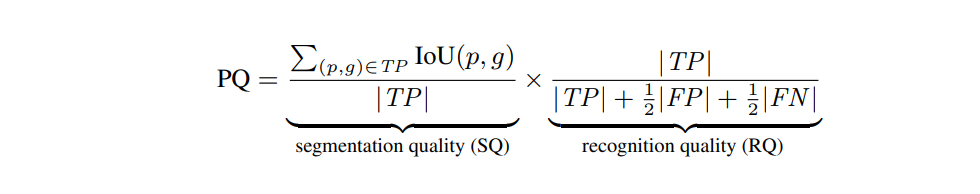
PQ can be decomposed into two components, the Recognition Quality (RQ) and Segmentation Quality (SQ). The RQ represents the F1 score, whilst SQ is the average IoU of matched segments [[8]](https://arxiv.org/pdf/1801.00868.pdf). Therefore, it measures the pixel-level class accuracy.

PQ is evaluated for each class independently and then averaged over the classes. The detection module of the torchmetrics package contains an existing panoptic quality evaluation measure called PanopticQuality [[10]](https://torchmetrics.readthedocs.io/en/stable/detection/panoptic_quality.html). The current version of the metric outputs the averaged PQ over all classes. In order to analyse the prediction capabilities of the model for each class, the  metric pipeline has been extended to output as well the PQ, SQ, and RQ of the individual classes. By computing class-specific metrics it will be possible to pinpoint the presence of overrepresented and underrepresented classes in the dataset, as well as the existence of class imbalance.   

Additionally, a benchmark evaluation process has been defined, which will compare the obtained metrics with the best models present in the Cityscapes Benchmark.

### Panoptic Quality Metric Computation

In [ ]:
# Initialisation of PanopticQuality metric.
# The PanopticQuality metric requires as input a set of ids for countable things (things) and for uncountable stuffs. 
metric_panoptic = PanopticQuality(things = things_ids, stuffs = label_ids_to_fuse_set).to(device)

The PanopticQuality metric, requires as input a torch tensor with shape [height, width, 2] which contains the pair (class_id, instance_id) for each pixel in the image. For pixels classified as stuff the instance_id is ignored [[10]](https://torchmetrics.readthedocs.io/en/stable/detection/panoptic_quality.html).

On the other hand, the current output of the model has been designed to produce for each input image a tensor of shape [height, width, 1], where the panoptic labels are specified as class_id * 1000 + instance_id for pixels defined as things and class_id for pixels defined as stuff. Therefore, the function `convert_panoptic_ids_evaluation` has been defined to process the output of the model into the appropiate format to be inputed into the metric.

In [ ]:
def convert_panoptic_ids_evaluation(panoptic_tensor):
    """
    Convert panoptic segmentation output to the required format for evaluation.

    Args:
        panoptic_tensor (torch.Tensor): The panoptic segmentation IDs tensor obtained from the model.

    Returns:
        panoptic_evaluation (torch.Tensor): The transformed panoptic evaluation tensor with format suitable for PanopticQuality metric.

    Note:
        The input `panoptic_tensor` is expected to have IDs encoded as follows:
        - IDs > 1000:  Combines class ID (divisions) and instance ID (remainders).
        - IDs <= 1000: Directly represents a class ID.
    """

    panoptic_evaluation = torch.zeros(panoptic_tensor.shape + (2,))

    indices = panoptic_tensor > 1000
    
    # Ensure index and tensor are on the same device
    indices = indices.to(device)
    panoptic_evaluation = panoptic_evaluation.to(device)
    
    divisions = panoptic_tensor[indices] // 1000
    remainders = panoptic_tensor[indices] % 1000


    # Assign the computed values to the corresponding positions in panoptic_evaluation
    panoptic_evaluation[:,:,:,0][indices] = divisions
    panoptic_evaluation[:,:,:,1][indices] = remainders

    # Assign the original values and zeros to positions for elements smaller than 1000
    panoptic_evaluation[:,:,:,0][~indices] = panoptic_tensor[~indices]
    panoptic_evaluation[:,:,:,1][~indices] = 0

    return panoptic_evaluation

In the cells below, a series of functions have been defined to update and compute the panoptic metric and store the results in an appropriate dictionary. The function `update_panoptic_metric_for_dataloader` involves resizing the model output. This is necessary because the model obtained from HuggingFace is inherently designed to output a downsized labeled image. To perform the pixel-wise computation of the metric for each image, the label and output images must have equal dimensions. Therefore, the output image needs to be resized. The nearest-neighbor interpolation method is chosen to preserve the discrete ID labels of the output.

However, as will be demonstrated below, the result of this nearest-neighbor interpolation leads to noticeable pixelated artifacts, especially pronounced since the resizing is executed by a large factor. Consequently, it causes a loss of fine details, distortion in object sizes, and misalignment with the ground truth. This effect is particularly significant for objects that are very small or possess highly irregular and complex shapes. The upsampling may introduce an overestimation of edge pixels, resulting in the overemphasis of outer object pixels for certain classes in the upscaled image. This can lead to an incorrect definition of object sizes and boundaries.

Additionally, it can significantly impact occluded or truncated objects, as the upsampling may further fragment segments of the occluded object by expanding and distorting its boundary. This makes it more challenging to correctly match different segments corresponding to a unique object. 

In conclusion, this required upsampling process results in incorrect pixel-wise matching, ultimately leading to a reduction in the quality of the output and lower PQ, RQ, and SQ metric scores.

It would be beneficial in future iterations to use alternative interpolation methods that restrict the above source of error, such as transposed convolution layers in CNNs or even more sophiscated algorithms such as  Conditional Generative Adversial Networks (cGANs) [[11]](https://arxiv.org/abs/1411.1784). These are able  to generate high resolution segmentation maps from the lower resolution inputs. The deployment of these intricate algorithms requires substantial computational resources. Therefore, due to the imposed computational constraints it was deemed more appropiate to favor more simple methodologies, albeit at the cost of diminished performance outcomes.

The function `update_panoptic_metric_for_dataloader` updates for each batch the panoptic metric.

In [ ]:
def update_panoptic_metric_for_dataloader(dataloader, id_print, annotations_json=None, set_type=None):
    """
    In-place update of the panoptic metric for each batch in a specific dataset, given by the dataloader.

    Args:
        dataloader (DataLoader): The dataloader containing input batches.
        id_print (int): The index of the image in the  visualization and annotation information (for debugging).
        
        The following inputs are required to visualise the original image, in addition to the output of the model and the labels.
        annotations_json (list, optional): The annotations JSON file (if available).
        set_type (str, optional): The type of dataset (e.g., 'train', 'val') of the dataloader (if available).
        
    """

    for idx, batch in enumerate(dataloader):
        output, labels_batch = compute_output_model(batch)
        labels_batch_ids = extract_panoptic_ids_inputs(labels_batch)

        output_resized = torch.zeros_like(labels_batch_ids)
        
        for i in range(output.shape[0]):
            output_resized[i,:,:] =F.interpolate(output[i,:,:].unsqueeze(0).unsqueeze(0), size=tuple(labels_batch_ids.shape[-2:]), mode='nearest').squeeze()

        if idx == id_print:
            if annotations_json is not None or set_type is not None:
                compute_original_image(labels_batch, annotations_json, set_type)
                
            visualize_segmentation(output_resized[0,:,:].cpu().numpy().astype(int), 'Panoptic', categories,rgb_to_class_id)
            visualize_segmentation(labels_batch_ids[0,:,:].cpu().numpy().astype(int), 'Panoptic', categories,rgb_to_class_id)

        output_resized = output_resized.to(torch.float32).to(device)
        labels_batch_ids = labels_batch_ids.to(torch.float32).to(device)

        # Correctly format index for panoptic segmentation
        panoptic_outputs_evaluation = convert_panoptic_ids_evaluation(output_resized)
        panoptic_labels_evaluation = convert_panoptic_ids_evaluation(labels_batch_ids)

        metric_panoptic.update(panoptic_outputs_evaluation, panoptic_labels_evaluation)
                
def extract_panoptic_result_dictionary(metric_panoptic):
    """
    Extract panoptic segmentation evaluation results as a dictionary.

    Args:
        metric_panoptic: The panoptic evaluation metric object.

    Returns:
        dict: A dictionary containing relevant information to compute panoptic segmentation metrics.

    """
    PQ_metrics=metric_panoptic.compute()
    panoptic_dict = {'iou_sum': metric_panoptic.iou_sum, 'true_positives': metric_panoptic.true_positives, 
                'false_positives':metric_panoptic.false_positives, 'false_negatives': metric_panoptic.false_negatives, 
                     'cat_id_to_continuous_id': metric_panoptic.cat_id_to_continuous_id }
    
    return panoptic_dict

def compute_output_model(batch):
    """
    Extract the encoded output and the labels for each image in a batch
    """
    
    pixel_values_batch = batch['pixel_values']
    pixel_mask_batch = batch['pixel_mask']
    labels_batch = batch['labels']
    
    pixel_values_batch=pixel_values_batch.to(device)
    pixel_mask_batch=pixel_mask_batch.to(device)

    with torch.no_grad():
        output = model.forward(pixel_values_batch, pixel_mask_batch)

    output = post_process_panoptic(output)
    return output, labels_batch

Once the above functions have been defined, the metric update is carried out. The metric is analysed for the sections of the dataset that are labelled, i.e. the train_dataloader and val_dataloader. In addition, to qualitatively analyse the panoptic segmentation results on these two datasets a random image id given by `idx_visualise` is selected from each dataloader and displayed.

In [ ]:
# Randonly define indices to print
idx_visualise = []
annotations = [annotations_json_train, annotations_json_val]
set_type = ['train', 'val']

for dataloader in [train_dataloader,val_dataloader]:
    idx_visualise.append(random.randint(0,len(dataloader) -1))

In [ ]:
%matplotlib nbagg

In [ ]:
class_names = list(categories.values())

metric_panoptic.reset()
for idx_dataloader, dataloader in enumerate([train_dataloader,val_dataloader]):
    update_panoptic_metric_for_dataloader(dataloader, idx_visualise[idx_dataloader], annotations[idx_dataloader], set_type[idx_dataloader])
    
panoptic_dict = extract_panoptic_result_dictionary(metric_panoptic)

### Visualise Panoptic Quality - Qualitative Analysis of Results

A subset of the test dataset is then utilised to perform a qualitative assessment of the model's panoptic segmentation performance, focusing specially on its generalisation ability. 

In [ ]:
for idx, batch in enumerate(test_dataloader):
    output, _ = compute_output_model(batch)
    visualize_segmentation(output[0,:,:].cpu().numpy().astype(int), 'Panoptic', categories,rgb_to_class_id)

### Quantitative Analysis Class Specific PQ, RQ and SQ and Benchmark Analysis
In the following section, the results of the PanopticQuality metric are processed to output the class-wise PQ, RQ and SQ, as well as the averaged values. It is important to note that the average PQ is computed with a constant weight for all classes.

A series of functions is first defined to collectively carry out the computation of evaluation metrics for panoptic segmentation. These functions encompass the calculations for Segmentation Quality (SQ), Recognition Quality (RQ), and Panoptic Quality (PQ) for both individual object classes and the entire model. The function 'compute_evaluation_metrics' serves as the central coordinator that outputs all the required metrics.

In addition, the `compute_PQ_SQ_RQ_values_per_class` function is defined to allow the visualization of metrics for the individual classes.

In [ ]:
def compute_sq_per_class(iou_sum, true_positives):
    return torch.where(true_positives > 0.0, torch.div(iou_sum, true_positives), 0.0)

def compute_rq_per_class(true_positives, false_positives, false_negatives):
    return torch.where(true_positives > 0.0, torch.div(true_positives, true_positives + 0.5*false_positives + 0.5*false_negatives), 0.0)

def compute_pq_per_class(sq_class, rq_class):
    return torch.mul(sq_class, rq_class)

def compute_sq_total(sq_class):
    return torch.mean(sq_class)

def compute_rq_total(rq_class):
    return torch.mean(rq_class)
                                      
def compute_pq_total(rq, sq):
    return rq * sq

def compute_evaluation_metrics(metric):
    # First compute per class metrics
    sq_per_class = compute_sq_per_class(metric['iou_sum'], metric['true_positives'])
    rq_per_class = compute_rq_per_class(metric['true_positives'], metric['false_positives'], metric['false_negatives'])
    pq_per_class = compute_pq_per_class(sq_per_class, rq_per_class)
                      
    # Now compute for all
    model = {'name': 'Detr Panoptic'}
    model['SQ'] = compute_sq_total(sq_per_class).item()*100
    model['RQ'] = compute_rq_total(rq_per_class).item()*100
    model['PQ'] = compute_pq_total(model['SQ'], model['RQ'])/100                    
                      
    return model, sq_per_class, rq_per_class, pq_per_class

In [ ]:
def compute_PQ_SQ_RQ_values_per_class(panoptic_dict):
    continuous_id_to_cat_id ={value: key for key, value in panoptic_dict['cat_id_to_continuous_id'].items()}
    class_names_semantic_id = [continuous_id_to_cat_id.get(i) for i in range(len(continuous_id_to_cat_id))]
    class_names_semantic = [categories[id_class] for id_class in class_names_semantic_id]

    sq_values = sq_per_class.cpu().numpy()
    rq_values = rq_per_class.cpu().numpy()
    pq_values = pq_per_class.cpu().numpy()

    
    plt.figure(figsize = (10, 6))
    stack_rq_higher = rq_values > sq_values

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(class_names_semantic, np.where(stack_rq_higher, rq_values, sq_values), color='g', label='RQ')
    ax.bar(class_names_semantic, np.where(stack_rq_higher, sq_values, rq_values), color='r', label='SQ')
    plt.bar(class_names_semantic, pq_values, color='b', label = 'PQ')

    plt.xticks(rotation='vertical')
    plt.xlabel('Class Names')
    plt.ylabel('Evaluation Values')
    plt.title('PQ, SQ, RQ Values per class')
    plt.tight_layout()
    plt.legend()
    plt.show()

In the following section, the metrics are computed and visualised. 

In [ ]:
own_model_evaluation_results, sq_per_class, rq_per_class, pq_per_class = compute_evaluation_metrics(panoptic_dict)

In [ ]:
compute_PQ_SQ_RQ_values_per_class(panoptic_dict)

Now the obtained PQ, SQ and RQ values obtained are compared with those achieved by the top 20 algorithms from the Cityscapes Benchmark

In [ ]:
df = pd.read_excel(os.path.join(benchmark_folder_path,'panoptic_benchmark.xlsx'), skiprows=1).iloc[:20]

In [ ]:
own_model_evaluation_results

In [ ]:
own_model_df = pd.DataFrame([own_model_evaluation_results])
df = pd.concat([df, own_model_df], ignore_index=True)

In [ ]:
PQ_values = df['PQ'].values
SQ_values = df['SQ'].values
RQ_values = df['RQ'].values
model_names = df['name'].values

plt.figure(figsize = (10, 10))
plt.bar(model_names, SQ_values, color='r', label = 'SQ')
plt.bar(model_names, RQ_values, color='g', label ='RQ')
plt.bar(model_names, PQ_values, color='b', label = 'PQ')

plt.xticks(rotation='vertical')
plt.xlabel('Model Name')
plt.ylabel('Evaluation Values')
plt.title('PQ Values for 10 best models')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
print('PQ: ' + str("{:.2f}".format(own_model_evaluation_results['PQ'])))
print('SQ: ' + str("{:.2f}".format(own_model_evaluation_results['SQ'])))
print('RQ: ' + str("{:.2f}".format(own_model_evaluation_results['RQ'])))

In [ ]:
del df

## Semantic Segmentation Evaluation
In Semantic Segmentation, the prominent metric is the Intersection over Union, defined for all classes as:

$IOU = \frac{TP}{TP + FN + FP}$

Note that $TP, FN, FP$ represent True Positions, False Nevatives and False Positives respectively. Then the average for all classes is taken to yield the Mean Intersection over Union $(MIoU$). 

The following section follows a very similar procedure to the Panoptic Segmentation Evaluation.  Initially, a set of functions is introduced to iteratively update the semantic metric for each dataloader. The code provides adaptability to different datasets namely IKA and Cityscapes. This adaptability enhances the code's reusability while also reducing the amount of boilerplate functions defined. Therefore, it allows the code to be applied and extended to a broad range of datasets and increases its efficiency by minimizing redundancy in function definitions.

The function `extract_semantic_result_dictionary` extracts a summary of the IoU for each class. The semantic segmentation of the selected images for each dataset are also visualised.

### Definition of Required Functions

In [ ]:
def update_semantic_metric_for_dataloader(dataloader, metric, dataset_name, id_print, categories, rgb_to_class_id, annotations_json=None, set_type=None):
    """
    Update semantic segmentation metric for a given dataloader.

    Args:
        dataloader (Dataloader): The dataloader containing batches of data to analyse.
        metric: The metric object to update.
        dataset_name (str): The name of the dataset ('Cityscapes' or 'IKA').
        id_print (int): The index of the image, whose's results are visualised.
        
        Optional parameters required for the visualisation of the original image
        annotations_json (dict, optional): Annotations in JSON format.
        set_type (str, optional): The type of dataset set ('train' or 'val').

    """
    
    # Iterate through batches in the provided dataloader
    for idx, batch in enumerate(dataloader): 
        
        # Compute model outputs and retrieve ground truth labels
        output, labels_batch = compute_output_model(batch)
        
        # Process labels based on the dataset name ('Cityscapes' or 'IKA')
        if dataset_name == 'Cityscapes':
            labels_batch_ids = extract_panoptic_ids_inputs(labels_batch)
            
        elif dataset_name == 'IKA':
            # Perform an ID conversion for 'IKA' dataset, transform  from Cityscapes to IKA IDs
            output = PanopticDatasetIka.cityscapes_id_to_ika_id_conversion(output)
            labels_batch_ids = torch.tensor(np.array(labels_batch))
            
        else:
            print('Please print an appropiate dataset name. Either Cityscapes or IKA')
        
        # Resize the model's output to match label dimensions
        output_resized = torch.zeros_like(labels_batch_ids)
        for i in range(output.shape[0]):
            output_resized[i,:,:] =F.interpolate(output[i,:,:].unsqueeze(0).unsqueeze(0), size=tuple(labels_batch_ids.shape[-2:]), mode='nearest').squeeze()

        output_resized = output_resized.to(torch.float32).to(device)
        labels_batch_ids = labels_batch_ids.to(torch.float32).to(device)

        # Apply semantic segmentation mapping to convert panoptic labels into semantic labels
        output_semantic = np.vectorize(mapping_semantic_segmentation)(output_resized.cpu().numpy()).astype(int)
        labels_semantic = np.vectorize(mapping_semantic_segmentation)(labels_batch_ids.cpu().numpy()).astype(int)        
        
        if (idx == id_print):
            # Visualize the original image.
            if annotations_json is not None or set_type is not None:
                compute_original_image(labels_batch, annotations_json, set_type)
            
            # Visualize the semantic segmentation results
            visualize_segmentation(output_semantic[0,:,:], 'Semantic', categories, rgb_to_class_id)
            visualize_segmentation(labels_semantic[0,:,:], 'Semantic', categories, rgb_to_class_id)
        
        # Update metric
        metric.update(torch.tensor(output_semantic), torch.tensor(labels_semantic))
        
def extract_semantic_result_dictionary(metric, class_names_categories):
    """
    Extract a dictionary of class-wise IoU metrics.

    Args:
        metric: The metric object containing computed IoU values.
        class_names_categories (List): List of class names.

    Returns:
        dict: A dictionary with class names as keys, and IoU values as values.
    """

    class_names = list(class_names_categories)
    IOU_class=metric.compute()
    iou_dict = dict(zip(class_names, IOU_class.cpu().numpy()))
    return iou_dict


### IoU metric update

Then the metric computation is carried out.

In [ ]:
metric_semantic = JaccardIndex(task="multiclass", num_classes=len(rgb_to_class_id), average = 'none')

In [ ]:
metric_semantic.reset()

for idx_dataloader, dataloader in enumerate([train_dataloader,val_dataloader]):
    update_semantic_metric_for_dataloader(dataloader, metric_semantic,'Cityscapes', idx_visualise[idx_dataloader], categories, rgb_to_class_id, annotations[idx_dataloader], set_type[idx_dataloader])

iou_dict = extract_semantic_result_dictionary(metric_semantic, categories.values())

### Qualitative Analysis

A qualitative analysis is then carried out on a subset of the test dataset.

In [ ]:
for idx, batch in enumerate(test_dataloader):
        output, _ = compute_output_model(batch)
        output = output.to(torch.float32).to(device)
            
        output_semantic = np.vectorize(mapping_semantic_segmentation)(output.cpu().numpy()).astype(int)
        visualize_segmentation(output_semantic[0,:,:], 'Semantic', categories, rgb_to_class_id)

### Quantitative Analysis Class Specific MIoU and Benchmark Analysis
In the following section, the results of the semantic metric are processed to visualise the per-class IoU, as well as the MIoU, and compare the results with the 20 top-performing models in the cityscapes benchmark.

In [ ]:
df = pd.read_excel(os.path.join(benchmark_folder_path,'semantic_benchmark.xlsx'), skiprows=1)

In [ ]:
## Print the IOU for each class
def compute_IOU_per_class(iou_dict):
    plt.figure(figsize = (10, 6))
    bars = plt.bar(iou_dict.keys(), [val for val in iou_dict.values()], label='IOU')

    plt.xticks(rotation='vertical')
    plt.xlabel('Class Names')
    plt.ylabel('IOU per class')
    plt.title('IOU')
    plt.tight_layout()
    plt.show()

In [ ]:
compute_IOU_per_class(iou_dict)

In [ ]:
## Mean IOU
def compute_mean_IOU(iou_dict):
    return (sum(iou_dict.values()))/(len(iou_dict)) * 100

MIoU = compute_mean_IOU(iou_dict)

# Now compute with 20 best models
df = pd.read_excel(os.path.join(benchmark_folder_path,'semantic_benchmark.xlsx'), skiprows=1).iloc[:20]
own_model_df = pd.DataFrame([{'name':'DETR Panoptic', 'IoU class':MIoU}])
df = pd.concat([df, own_model_df], ignore_index=True)

In [ ]:
IoU_class = df['IoU class']
model_names = df['name'].values

plt.figure(figsize = (10, 6))
plt.bar(model_names, IoU_class, color='g', label ='mIoU')


plt.xticks(rotation='vertical')
plt.xlabel('Model Name')
plt.ylabel('Evaluation Values')
plt.title('MIoU for 20 best models')
plt.tight_layout()
plt.show()
plt.savefig(str(100))


In [ ]:
print('MIoU achieved: ' + str("{:.2f}".format(MIoU)))

## Instance Segmentation Qualitative Evaluation

In [ ]:
for idx, batch in enumerate(test_dataloader):
    output, _ = compute_output_model(batch)
    visualize_segmentation(output[0,:,:].cpu().numpy().astype(int), 'Instance', categories,rgb_to_class_id)

## Evaluation of Semantic Segmentation Capabilities in a different Dataset - IKA

In order to analyse the generalisation capabilities of the developed model and its applicability to real-world scenarios, it is required to assess its performance in another dataset. In this case, the IKA dataset is selected. The choice of IKA as the evaluation dataset is well-justified based on its relevance to the autonomous driving domain and its similarity to the Cityscapes dataset. ADD It's worth noting that the dataset comprises of images captured in Aachen, Germany, which bears similarities in terms of traffic signals and urban environments to some of the images in the Cityscapes dataset. However, there are notable differences, primarily in the annotations provided. In comparison to the Cityscapes dataset, the annotations in the IKA dataset are coarser. In addition, the IKA dataset contains a reduced subset of Cityscapes classes, meaning that many of the semantic classes of the original dataset are reduced to a common class. This reduction can be visualised in [Section: Mapping Cityscapes and IKA Classes](###Mapping-Cityscapes-and-IKA-Classes
)

These differences enable the analysis of the model's capacity to generalize to new environments and recognize objects with precision. As seen in the previous experiments, the model exhibited bad performance in delineating fine and smooth boundaries for objects, specially for smaller, less frequently seen objects. In addition, as a result of class imbalance, the model tended to overpredict certain classes specially with respect to classes that shared similar features. For example all 'Caravan' classes were often mapped simply to 'Bus'. Therefore, this class reduction has several benefits. It mitigates the model's inclination to overpredict specific categories, thus enhancing its accuracy. Additionally, it simplifies the class-wise evaluation process, reducing complexity, and subsequently, computational demands.

Furthermore, it is important to emphasize that this streamlined dataset proves to be sufficiently effective for autonomous driving applications. The groupings have been carried out in a way such that the agent employs uniform interaction strategies across grouped classes. For example, a limitation of the model that was determined from visual inspection, is the model's ability to distinguish between classes terrain and vegetation. In the streamlined dataset, these distinctions have been grouped into a singular category, namely, "vegetation." Consequently, the model does not have to learn to discern subtle differences among visually similar objects that do not correspond to critical categories or that share equivalent interaction strategies. Instead the model learns to classify objects into broader classes that efficiently and robustly ensure safe and efficient navigation. Analyzing the results obtained from this simplified dataset will help identify the procedures for future model refinement.

However, this dataset only allows us to analyse the generalisation capabilities related to semantic segmentation, since the IKA dataset only contains semantic labels. Therefore, IKA serves as a simplified representation of autonomous driving scenarios, mirroring many characteristics of Cityscapes while being more manageable.


### Mapping Cityscapes and IKA Classes
In the following section a mapping between the Cityscapes and the IKA dataset class id is defined. From the IKA dataset, the dictionary `rgb_to_class_id` is obtained. This dictionary defines the class reduction by mapping the Cityscapes class colour to the reduced ID. Therefore, a pipeline has been developed to extract from this information a direct mapping between Cityscapes ID and IKA ID.

For the purpose of visualization, the grouped IKA class randomly select as its representation colour one of the colours from its constituent Cityscapes classes.

In [62]:
# Class reduction mapping of labels between Cityscapes and IKA dataset

# Initialize a dictionary to store the mapping between Cityscapes class IDs and IKA class IDs
cityscapes_id_to_ika_ids = {}

for cityscapes_id, color_rgb in rgb_to_class_id.items():
    if tuple(color_rgb) in color_to_ika_ids:
        ika_id = color_to_ika_ids[tuple(color_rgb)]
        cityscapes_id_to_ika_ids[cityscapes_id] = ika_id
        
# Initialize a dictionary to store the mapping between IKA class IDs and their RGB colors for visualisation.
ika_ids_to_color = {}
for color, id_ in color_to_ika_ids.items():
    if id_ not in ika_ids_to_color:
        ika_ids_to_color[id_] = color
        
# Print 
print(cityscapes_id_to_ika_ids)

{0: 11, 5: 11, 6: 11, 7: 0, 8: 1, 9: 11, 10: 11, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4, 22: 4, 23: 5, 24: 6, 25: 7, 26: 8, 27: 9, 28: 10, 29: 10, 30: 8, 31: 11, 32: 7, 33: 7, 34: 8}


The `cityscapes_id_to_ika_ids` map does not contain mapping for classes 1 - 4, these correspond to classes: 'Rectification Border', 'Out-of-roi', 'Static', 'Ego vehicle'. Therefore these need to be added manually and reduced to the None class with Id 11.

In [63]:
for new_id in range(1, 5):
    cityscapes_id_to_ika_ids[new_id] = 11

In [64]:
# Visualisation that the mapping has been carried out correctly
ika_id_to_class_name = {
    0: 'Road',
    1: 'Sidewalk',
    2: 'Building',
    3: 'Pole',
    4: 'Vegetation',
    5: 'Sky',
    6: 'Person',
    7: 'Two Wheeler',
    8: 'Car',
    9: 'Truck',
    10: 'Bus',
    11: 'None'
}

ika_id_to_cityscapes_id = {}

for cityscapes_id, ika_id in cityscapes_id_to_ika_ids.items():
    if ika_id not in ika_id_to_cityscapes_id:
        ika_id_to_cityscapes_id[ika_id] = []
    ika_id_to_cityscapes_id[ika_id].append(cityscapes_id)

# Print any missing Ids
missing_ids = [id for id in range(0, 34 + 1) if id not in cityscapes_id_to_ika_ids]

if len(missing_ids) == 0:
    print("No Missing IDs")
else:
    print("Missing IDs:", missing_ids)
    
# Print the visualization
print("="*30)
for ika_id, cityscapes_ids in ika_id_to_cityscapes_id.items():
    print(f"IKA Class: {ika_id_to_class_name[ika_id]}")
    print("Cityscapes Classes:")
    for cityscapes_id in cityscapes_ids:
        print(f"- {categories[cityscapes_id]}")
    print("="*30)

No Missing IDs
IKA Class: None
Cityscapes Classes:
- unlabeled
- dynamic
- ground
- parking
- rail track
- train
- ego vehicle
- rectification border
- out of roi
- static
IKA Class: Road
Cityscapes Classes:
- road
IKA Class: Sidewalk
Cityscapes Classes:
- sidewalk
IKA Class: Building
Cityscapes Classes:
- building
- wall
- fence
- guard rail
- bridge
- tunnel
IKA Class: Pole
Cityscapes Classes:
- pole
- polegroup
- traffic light
- traffic sign
IKA Class: Vegetation
Cityscapes Classes:
- vegetation
- terrain
IKA Class: Sky
Cityscapes Classes:
- sky
IKA Class: Person
Cityscapes Classes:
- person
IKA Class: Two Wheeler
Cityscapes Classes:
- rider
- motorcycle
- bycicle
IKA Class: Car
Cityscapes Classes:
- car
- trailer
- license plate
IKA Class: Truck
Cityscapes Classes:
- truck
IKA Class: Bus
Cityscapes Classes:
- bus
- caravan


Now if we compare the above with the color-coding-reduction.png provided, it can be seen that the mapping has been done correctly
![Color Coding Reduction](./images/colorcodingreduction.png)


### Ika Dataset Required Preprocessing

Since the format of `the ika_dataset labels`is slightly different to the cityscapes labels. The data needs to be transformed into the correct format for the model. For this purpose we have to transform the rgb encoding of the label to an id encoding. The preprocessing steps in addition to the PanopticDataset class specifically designed for the IKA dataset are described below. 

In [65]:
# Set path to convert Cityscapes Panoptic Dataset to COCO
dataset_path_ika = 'data/ika-dataset/acdc-rp_topic-01_data/acdc-rp_topic-01_data/ika-dataset'

In [66]:
class PanopticDatasetIka(Dataset):
    
    def __init__(self, dataset_path,feature_extractor):
        self.dataset_path = dataset_path
        self.feature_extractor = feature_extractor
        self.image_paths = sorted([os.path.join(self.dataset_path, 'input' ,filename) for filename in os.listdir(os.path.join(self.dataset_path, 'input')) if filename.endswith('.png')])
        self.label_paths = sorted([os.path.join(self.dataset_path,'label',filename) for filename in os.listdir(os.path.join(self.dataset_path, 'label')) if filename.endswith('.png')])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,index):
        image_data, panoptic_ids = self.extract_ids_from_image(self.image_paths[index], self.label_paths[index])
        return image_data, panoptic_ids
    
    def extract_ids_from_image(self, image_path, label_path):
        # Load the image and the panoptic segmentation
        image_data = np.array(Image.open(image_path))        
        semantic_seg = np.array(Image.open(label_path))
        
        semantic_seg_ids = self.ika_color_to_id(semantic_seg)     
        encoding = self.feature_extractor(images=image_data, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = semantic_seg_ids
        return pixel_values, target.astype(int)

    @staticmethod
    def ika_color_to_id(image_rgb):
        
        """Converts a IKA RGB label to an image array with corresponding IKA IDs"""
        
        image_id = np.zeros((image_rgb.shape[0], image_rgb.shape[1], 1))
        
        mask = np.ones_like(image_id, dtype=int)
        
        for color, id_ in color_to_ika_ids.items():
            array_with_tuple = np.full((image_rgb.shape[0], image_rgb.shape[1], 3), color)
            criterion = np.logical_and(image_rgb[:,:,:3] == color,  np.repeat(mask, 3, axis=-1))
            criterion_reduced = np.all(criterion, axis = -1, keepdims = True)
            image_id[criterion_reduced] = id_
            mask[criterion_reduced] = 0
            
        image_id = np.squeeze(image_id)
        return image_id
    
    @staticmethod
    def cityscapes_id_to_ika_id_conversion(image_id_cityscapes_tensor): 
        
        """
        Takes a Cityscapes ID tensor as input and converts it to the corresponding IKA  ID tensor using a predefined mapping.

        Args:
            image_id_cityscapes_tensor (tensor): A tensor containing Cityscapes IDs to be converted.

        Returns: A tensor containing the converted IKA IDs.

        """
        
        image_id_ika = torch.zeros_like(image_id_cityscapes_tensor)
        
        mask = torch.ones_like(image_id_ika, dtype=int)
        
        for cityscapes_id, ika_id in cityscapes_id_to_ika_ids.items():
            criterion = torch.logical_and(image_id_cityscapes_tensor == cityscapes_id, mask)
            image_id_ika[criterion] = ika_id
            mask[criterion] = 0
            
        return image_id_ika

In [67]:
# Define dataset and daloader
dataset_ika = PanopticDatasetIka(dataset_path_ika,feature_extractor)
evaluation_ika_dataloader = DataLoader(dataset_ika, collate_fn=collate_fn, batch_size=1, shuffle=True)

<IPython.core.display.Javascript object>


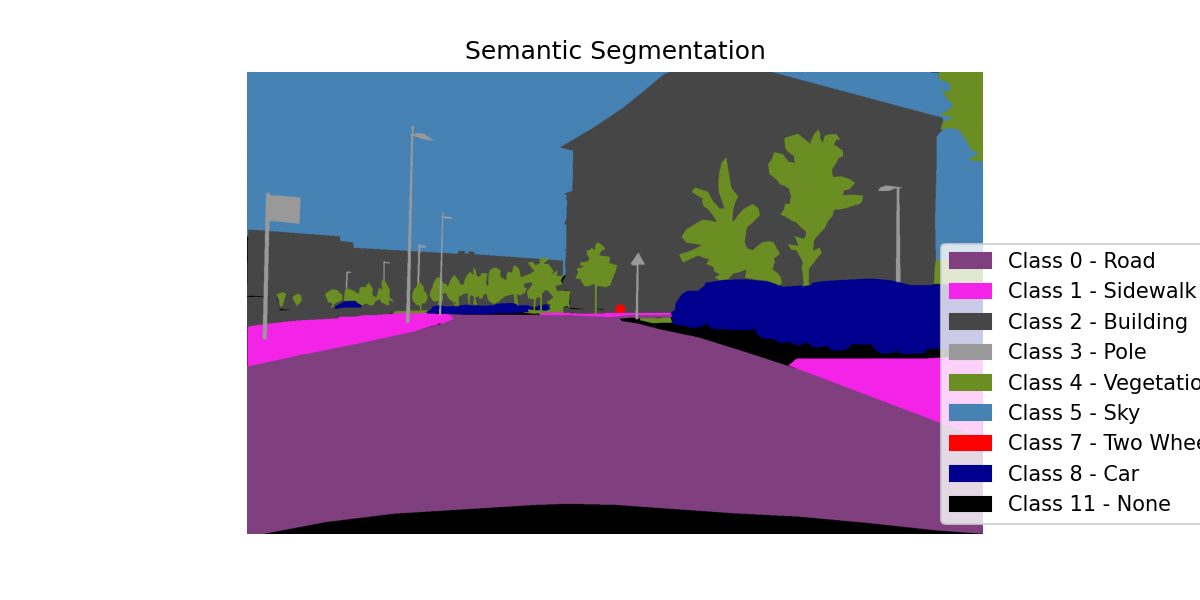

saved


C:\Users\vtshu\AppData\Local\Temp\ipykernel_3156\1277476548.py:132: UserWarning: Matplotlib is currently using nbAgg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [68]:
# Visualise Semantic Segmentation Labels
image, ids_image_0 = dataset_ika.__getitem__(0)

# Semantic Segmentation
visualize_segmentation(ids_image_0, 'Semantic', ika_id_to_class_name, ika_ids_to_color)

In order to guarantee the accuracy of the ID conversion, a visual inspection is carried out. It can be seen that the label contains additional colours, which are mapped to the colour of the reduced task in the output after the ID conversion.

![Label IKA FIrst](data/ika-dataset/acdc-rp_topic-01_data/acdc-rp_topic-01_data/ika-dataset/label/2_frame_000159_gtFine_labelColor.png)


In [69]:
%matplotlib nbagg

<IPython.core.display.Javascript object>

saved


C:\Users\vtshu\AppData\Local\Temp\ipykernel_3156\1277476548.py:132: UserWarning: Matplotlib is currently using nbAgg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


<IPython.core.display.Javascript object>


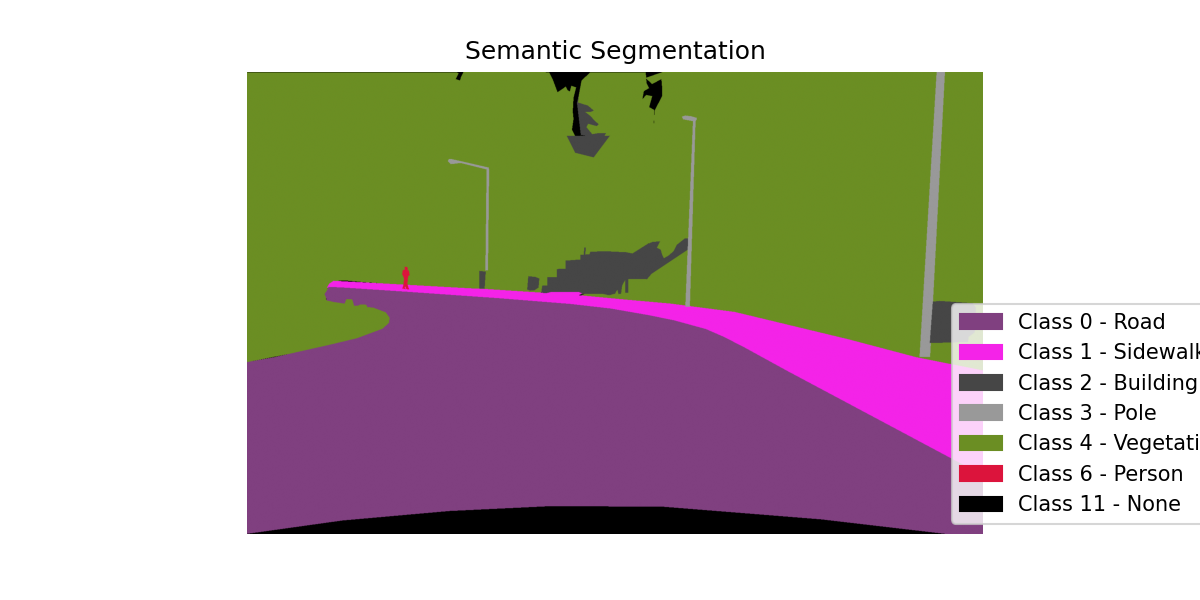

saved


In [70]:
# Metric Update
metric_semantic_ika = JaccardIndex(task="multiclass", num_classes=len(ika_id_to_class_name), average = 'none')

metric_semantic_ika.reset()
update_semantic_metric_for_dataloader(evaluation_ika_dataloader, metric_semantic_ika,'IKA', random.randint(0, len(evaluation_ika_dataloader) - 1), ika_id_to_class_name, ika_ids_to_color)

In [71]:
# Extraction of results
iou_dict_IKA = extract_semantic_result_dictionary(metric_semantic_ika, ika_id_to_class_name.values())

In [72]:
# Displaying of results
compute_IOU_per_class(iou_dict_IKA)

<IPython.core.display.Javascript object>

C:\Users\vtshu\AppData\Local\Temp\ipykernel_3156\4105355033.py:11: UserWarning: Matplotlib is currently using nbAgg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [73]:
# Compute mIOU values
mIOU_IKA = compute_mean_IOU(iou_dict_IKA)
print(mIOU_IKA)

27.32655042782426


# Evaluation

## Training Process

**Comparative Analysis of Training and Validation Loss**

The process of training a panoptic segmentation model is characterized by a dynamic interplay between learning and generalization. As the model iteratively refines its internal representations, it aims to strike a delicate balance between minimizing errors on the training dataset while maintaining its ability to generalize to unseen data. A pivotal aspect of assessing model performance and convergence lies in the analysis of training and validation losses. In this section, we delve into the comprehensive evaluation of different model training runs by scrutinizing the patterns exhibited by their training and validation loss curves.

**Training Loss Dynamics:**

The training loss serves as a guiding beacon throughout the training process, encapsulating the dissimilarity between the model's predictions and the ground-truth annotations within the training dataset. As training progresses, the training loss is expected to exhibit a steady decline. This downward trend signifies that the model is effectively adapting to the dataset's intricacies, optimizing its parameters to minimize errors. However, it's crucial to monitor potential fluctuations or sudden drops in the training loss, as these can indicate phenomena such as gradient vanishing, poor initialization, or overly aggressive learning rates.

**Validation Loss Generalization:**

While the training loss offers insights into the model's convergence on the training data, the validation loss assumes a paramount role in evaluating the model's capacity to generalize. The validation loss quantifies the model's performance on an independent validation dataset that it has not seen during training. A rising validation loss, when compared to the training loss, can suggest overfitting—a situation where the model becomes too specialized to the training data and fails to generalize to new samples. Conversely, a consistent or decreasing validation loss indicates successful generalization, reinforcing the model's ability to capture underlying patterns rather than memorizing specific examples.

**Comparative Analysis:**

By plotting the training and validation loss curves across multiple training runs, we can glean valuable insights into the efficacy and stability of the model's learning dynamics. Comparing the trajectories of different training sessions reveals trends in model performance and convergence. When interpreting these curves, it is essential to consider factors such as hyperparameters, dataset composition, and architectural changes that may influence the observed patterns.

If training loss consistently outperforms the validation loss, it could indicate overfitting—a sign that the model may benefit from regularization strategies such as dropout, weight decay, or early stopping. Conversely, if the validation loss remains relatively high even as the training loss diminishes, the model may require adjustments to its architecture, hyperparameters, or data augmentation techniques to enhance generalization.



**Model Configuration and Representations**

In our pursuit of optimizing panoptic segmentation performance, we conducted several model training experiments, each characterized by distinct configurations and dataset sizes. 

In [2]:
import os
print(os.getcwd())


C:\Users\UX534\Documents\RWTH\ACDC - Research Project


**Model 80 vs. Model 119: Impact of Collate Function Change**

In our experimentation process, Model 80 utilized an older collate function, while Model 119 adopted a newer collate function. These collate functions are integral for preparing and organizing data during training. 
We initially used a pretrained model from the Hugging Face repository, which included a specific collate function. However, due to changes or removal of this function in subsequent versions, we encountered challenges in maintaining consistency. As a result, we had to transition to a new collate function.
It's important to note that the new collate function didn't produce results that were as good as the previous one. Nevertheless, we proceeded with the new collate function for the sake of continuity. All the subsequent models we present in our study are based on this new collate function.The graph highlights the discernible difference that collating function modifications can have on model performance and training dynamics by showing the clearly different validation loss between Model 80 and Model 119.
![80 vs 119- Collate](./images/80vs119Collate.png)

**Model 119 & Model 125: Comparison of model with and without Augmentation**

In this experimental setup, our main goal is to compare two models—one with augmentation (Model 125) and one without augmentation (Model 119)—in order to evaluate the influence of data augmentation. Training errors for both models show encouraging trends and are gradually declining, demonstrating that the models are successfully adjusting and optimizing their parameters.
Furthermore, both models attain comparable lowest loss values for validation loss. It's important to notice, however, that Model 119 exhibits an odd behavior in which its validation loss reaches a plateau before increasing, pointing to overfitting.
It's important to note that Model 125 features color space augmentation particularly, with geometric space augmentation having the ability to be included in future revisions for even better results.
This comparison emphasizes the importance of data augmentation in improving model generalization and reducing overfitting, resulting in segmentation results that are more robust and trustworthy.
![119vs125train.png](./images/119vs125train.png)
![119vs125val.png](./images/119vs125val.png)

**Model 119 & Model 97_V2: Scalability Assessment with Larger Dataset**

We introduced Model 97_V2 to test the model's scalability with a larger dataset, building on the lessons from Model 119. We expanded the dataset in this iteration from 1200 to 2975 samples, adding more complexity and diversity to the training set. This extension was carried out in phases, with Model 97_V2 serving as the last stage.

This expansion was done to see if the model could handle a wider variety of urban environments. It also planned to keep enhancing the functionality of the panoptic head and backbone parts. We wanted to evaluate the model's ability to generalize across a wider range of real-world circumstances by examining this larger-scale adaptation.
Please note that this experiment allowed us to examine the model's scalability by examining how well it responds to a larger and more varied dataset.

![Model119v97v2train.png](./images/Model119v97v2train.png)
![Model119v97v2val.png](./images/Model119v97v2val.png)

**Model 109_v2 & model 112_v2: Transformer Freezing**

We investigated the effects of freezing the transformer layers in this experiment. It's important to remember that due to time restrictions, we haven't finished the entire training process. Instead, these results are based on just 10 epochs. The performance measurements show a promising downward trend, despite the little instruction, suggesting room for development.
In this experiment, we explored the impact of freezing the transformer layers. It's important to note that we haven't completed the full training process; these results are based on only 10 epochs due to time constraints. However, despite the limited training, we can observe a promising downward trend in the performance metrics, indicating the potential for improvement.
This experiment serves as a preliminary investigation of the advantages of transformer freezing in our model architecture, but please note that additional training and optimization could result in even better outcomes.

![109vs112val.png](./images/109vs112val.png)
![109vs112train.png](./images/109vs112train.png)

**Model 80 vs. Model 72: ReLU Activation in Classification Head**

We added a classification head to the training process for the Cityscapes dataset in order to adapt the model, which was initially created for the COCO dataset with over 250 classes. With only 35 classes, this classification head is essential for fine-tuning the Cityscapes model.
In order to improve this classification head's capacity to adjust to the new dataset, we first tried including a ReLU (Rectified Linear Unit) activation function during training. Contrary to what we had anticipated, ReLU activation's inclusion produced less than ideal outcomes. Upon further analysis, we hypothesized that the primary reason behind this outcome is the linearity of the mapping required for this task.
In essence, the classification process inherently involves a linear mapping from the model's learned features to the output classes. As such, the introduction of an activation function like ReLU might not be necessary and could potentially disrupt this linear mapping. Consequently, we opted to train Model 80 without the ReLU activation function in the classification head. This change produced better outcomes, indicating that in this particular situation, a linear mapping was sufficient for efficient adaptation to the Cityscapes dataset. Notably, as shown in the graph, we found that training with ReLU resulted in larger validation losses than training without ReLU.
This decision highlights the importance of carefully tailoring model components to the specifics of the target dataset and task, as well as the potential consequences of introducing non-linearities in the learning process.
![80vs72ReLU.png](./images/80vs72ReLU.png)

In conclusion, our exploration of a wide range of model configurations, including Model 119, Model 125, Model 97_v2, Model 80, Model 72, and others, reflects a painstaking voyage through the complex world of panoptic segmentation. These setups incorporate particular training techniques, considerations for the dataset, and modifications to the model's constituent parts. Our investigation into these models goes beyond simple testing; it represents a focused effort to identify the complex connections between various elements, dataset scales, and learning dynamics.

# **6. Conclusion**

In this comprehensive report on panoptic segmentation, our exploration has led us through various critical aspects of panoptic segmentation, ranging from dataset considerations to model selection, hyperparameter tuning, training methodologies, and rigorous evaluation. We meticulously analyzed the datasets at our disposal, including the widely used Cityscapes dataset and the specific IKA dataset. While Cityscapes offered a valuable benchmark for model training, the IKA dataset proved instrumental for real-world inference, albeit with reduced classes and coarser annotations. The urban scenarios and similar traffic environments in the images from both datasets facilitated the development of robust models.
Choosing the right model architecture is paramount, and we opted for the DETR-Panoptic model, a powerful transformer-based architecture. Its unique combination of semantic and instance segmentation capabilities promised superior performance in capturing intricate details while maintaining efficiency. These hyperparameters were judiciously selected to strike a delicate balance between model expressiveness, convergence stability, and generalization capabilities.Our training process spanned various methodologies, including freezing the transformer, fine-tuning, and augmenting the dataset. We performed exhaustive experiments to analyze the impact of each method. 

We have explored a number of model configurations, including Model 119, Model 125, Model 97_v2, Model 80, Model 72, and others, and the results have given us priceless insights into the complex dynamics of panoptic segmentation. These models are evidence of our dedication to expanding the realm of computer vision's potential. Our models are being improved upon and adjusted as we go along, putting us in a position to provide solutions that excel at panoptic segmentation. Notably, freezing the transformer while training other components can be a significant advantages, emphasizing the importance of a well-balanced training strategy. The evaluation phase was a meticulous process, where the Panoptic Quality (PQ) metric took center stage. We carefully dissected PQ into Recognition Quality (RQ) and Segmentation Quality (SQ), considering class-specific analysis to provide a more nuanced view of our model's performance. Additionally, benchmark evaluations allowed us to contextualize our results within the broader research landscape.

In the inference phase on the IKA dataset, we successfully applied our panoptic segmentation model to real-world urban scenarios, bridging the gap between research and practical applications. The ability to map the model's output to the specific needs of the IKA dataset was pivotal for achieving accurate and meaningful results. In conclusion, this report encapsulates the comprehensive journey of panoptic segmentation. Through meticulous dataset selection, model architecture choices, hyperparameter tuning, training strategies, and rigorous evaluations, we have laid the groundwork for advancing the field of computer vision. Panoptic segmentation, as exemplified by this report, is a key enabler of the AI-driven future, where machines truly see and understand the world around them.


## Evaluation Results Analysis
In the following section, an in-depth analysis of the panoptic segmentation results is conducted. For the model 119, the class-wise panoptic and segmentation metrics are displayed below.
![PQ_Values_119](./images/PQValues119.png)
![SemanticSeg_Values_119](./images/Semanticclasswise119.png)

In addition, the PQ, SQ, RQ and MIoU metrics obtained are presented in the table below:
![Resultsmodel119](./images/resultsmodel119.png)

In addition, the comparison of our model with the best models in the Cityscapes Benchmark is displayed below.
![PQBenchmark](./images/PQBenchmark.png)
![SemanticBenchmark](./images/SemanticBenchmark.png)

From Figure "PQ, SQ, RQ Values per class", it can be observed that the highest-performing classes are 'Road,' 'Building,' 'Vegetation,' and 'Sky.' Several key factors can be attributed to this observation. On one hand, these classes are the most abundantly annotated in the dataset, as depicted in the figure below [[12]](https://arxiv.org/pdf/1604.01685.pdf). This abundance of pixel annotations enables more robust representations to be learned by the model for these classes, since it allows a wider range of scales, orientations and contexts for that class to be captured.
![classabundancecityscapes](./images/classabundancecityscapes.png). 

Additionally, for the most part, these classes have very distinctive visual features and textures therefore the model easily recognises these classes.

In the case of the 'Vegetation' class, the model demonstrates a good capability in correctly identifying and segmenting larger instances of vegetation, such as trees. However, notable challenges are encountered when the model is tasked with discerning smaller vegetation elements, notably bushes, often leading to their misclassification as 'Terrain'. Therefore, it can be seen that the model has suffered from class-specific overfitting.  This phenomenon can be attributed to an imbalance in representation among different subcategories of vegetation or potential ambiguity in the annotations. Due to visual similarities between very small vegetation and terrain, subjectivity may have influenced the accuracy of the annotations. As a potential solution, augmenting the training data with additional examples of small vegetation could be considered to address the subcategory imbalance.

This can be seen in the figures below. The first figure corresponds to the output of the model and the second figure to the corresponding label.
![Terrainvsvegetationlabelled](./images/Terrainvsvegetationlabelled.png)
![terrainvegetationlabel](./images/terrainvegetationlabel.png)

The high-performing classes are closely followed by 'Car' and 'Sidewalk'. The 'Car' class can be seen to achieve a similar RQ value compared to the high-performing classes. This indicates that the model is good at recognizing and correctly identifying the instances of cars. However, the low SQ values demonstrates that the model finds it challenging to accurately delineate boundaries of the instances. As a result of the low SQ, the PQ is low as well. 

The difficulty in finding a clear pixel-wise boundary between different instances of cars, is due to the size variability between different object instances and the fact that this object is highly occluded by other objects of the same class. As can  be seen in the Figure below, the model correctly classifies all cars that are nearer to the capturing camera, even if partially occluded. On the other hand, the boundary of cars that are further away is less well-defined and often they are fused into a single object, remaining pixels receive the void label or the label of the surrounding class. The low performance in smaller objects that are further away into the image horizon is due to inherent inefficiency of DETR to detect small objects or objects that are nearer to the horizon [[1]](https://arxiv.org/pdf/2005.12872.pdf). Below the output of the model and the label can be seen. 


![carclassoutput](./images/carclassoutput.png)
![carclassoutputlabel](./images/carclassoutputlabel.png)

From the semantic segmentation per-class MIoU results it can be seen that the class 'Car', now performs similarly to the high-performing classes. This further highlights the ability of the model to correctly classify and segment this class, but it's weakness in correctly delineating it's boundaries.

Thing classes such as 'Person', 'Bycicle', 'Rider', 'Bus', 'Truck' and 'Motorcycle' have very similar low PQ and SQ values. This is because these clases share many common features such as object size and context in the image. Therefore, the model performs similarly. For example, 'Person' and 'Bycicle' are often relatively small with complex and varied shapes and orientations. The lower performance of these things classes compared to the high-performing things class 'Car' can be due to their smaller occurance in the dataset and their relatively smaller object size on average.

In the case of objects characterized by small dimensions and intricate shapes, which frequently partially occlude high-performing classes such as traffic lights and background trees, or poles and parked cars in the vicinity, a prevalent occurrence is the deformation of their predicted shapes. This deformation tendency stems from the model's inclination to overestimate the boundaries of the high-performing objects, at times even subsuming or entirely obscuring the small object. This can clearly be seen in the figure used to analyse the class-specific overfitting, where the model tends to overestimate the class 'Building' partially absorbing class 'Pole'. This results in very small SQ and PQ values.

The first figure is the output of the model and the second figure is the label.
![Object Occlusion](./images/objectocclusion.png)
![Object Occlusion](./images/objectocclusionlabel.png)


It can be seen that there are many classes that have a PQ, SQ and RQ of 0. This means that the model does not correctly recognise and segment these classes. The model underwent training using a reduced subset of the training dataset. Consequently, it is likely that the model had limited exposure to these classes. This limited exposure may have hindered the model's ability to learn discerning features and discriminative representations, as a result, during inference, these objects are misclassified as classes with very similar features. For example, misclassification of a 'Caravan' object as a 'Bus', or for an object with label 'Trailer' as 'Truck'. Additionally small object size and occlusions for objects like 'License Plate', as discussed previously, may influence the inability of the model to segment these classes.

To overcome these issues and improve the PQ, SQ and RQ metrics, we can consider  it would be necessary to train the model for the full `train_dataset` so that the model achieves a better class balance and so that it sees a broader range of object class, sizes, shapes, orientations and occlusion scenarios, therefore improving generalisation capabilities of the model. An additional way of doing this would be to apply data augmentation, specifically geometric augmentation techniques to increase the model's exposure to objects pertaining to this class with different orientations, scales and contexts in the image.
 
It must be noted tha the pixelated images displayed in the visual analysis results from the need for an upsampling operation as described previously.

The output of the model yields a score value for each prediction. Therefore, when calling the `feature_extractor.post_process_panoptic_segmentation` function, it is required to specify the variables `threshold` and `mask_threshold`. `Threshold` defines the value used to filter out queries. and `mask_threshold` is the threshold used when turning the predicted masks into binary values [[13]](https://github.com/huggingface/transformers/blob/main/src/transformers/models/detr/image_processing_detr.py). A manual threshold optimization process was carried out using a subset of 20 images and measuring the resulting mIOU. The same 20 images were used for all thresholds to ensure that the disparity in the metric was only due to the threshold. Although the variations in the performance parameters can be seen to be very low, the `threshold` and `threshold_mask` is still chosen as the one that optimises the performance metric, i.e. corresponding to 0.5 and 0.5 respectively. 

| Threshold | Mask Threshold | PQ | SQ | RQ | mIOU |
| --- | --- | ---  | --- | --- | --- |
| 0.4 | 0.4 | 3.71 | 22.84 | 16.23 | 15.97 |
| 0.5 | 0.5 | 3.78 | 23.64 | 16.00 | 15.97 |
| 0.6 | 0.6 | 3.24 | 21.40 | 15.16 | 16.86 |
| 0.7 | 0.7 | 3.00 | 21.39 | 14.02 | 16.21 |
| 0.8 | 0.8 | 2.97 | 19.78 | 14.99 | 15.58 |

An additional source of error within the framework of our training process stems from the presence of labeling inaccuracies in both the training and validation datasets. For illustration,a sample image from the Cityscapes validation dataset is selected to represent the labeling errors encountered in the dataset. In the figures below, the original image, the label and the output of the model are presented.
![originallabelmannequin](./images/originallabelmannequin.png)
![misclassified](./images/misclassified.png) 
![misclassifiedlabel](./images/misclassifiedlabel.png)

As it can be seen, there are missing labels corresponding to the 'Road' and 'Sidewalk' classes, despite the model's accurate identification of these elements within the image. For fully-supervised object detection methods, the missing rate of annotations largely affects the performance of the model, as described in [[14]](https://openaccess.thecvf.com/content_CVPRW_2019/papers/Weakly%20Supervised%20Learning%20for%20Real-World%20Computer%20Vision%20Applications/Xu_Missing_Labels_in_Object_Detection_CVPRW_2019_paper.pdf).
The source of the error arises from either missing labels in the Cityscapes Dataset or errors in the `convert2panoptic` from the `cityscapesScripts` module, which transforms Cityscapes labels to Cityscapes panoptic labels. 

It is noteworthy to observe that, in the image presented above, the model wrongly classifies a mannequin as a 'Class Person - Instance 2'. This classification demonstates a nuanced challenge related to the model's ability to distinguish between classes that share similar visual characteristics, in this case between a real person and a mannequin. Nevertheless, in the autonomous driving domain,  these kind of detailed classifications of non-critical classes are not required for safe and efficient driving, as they will never interact with the agent. Consequently, it is considered that this type of misclassifications, although present, do not  compromise the model's performance, given its limited relevance to the primary task at hand. As such, no additional effort should be allocated to the correct classification of these less critical classes


Therefore, in future iterations of the model it would be necessary to undertake an investigation aimed at quantifying the extent of these missing labels and assess their impact.  Especially assesing whether these missing labels occur most often in certain classes. To achieve this, self-training and confidence thresholding can be employed [[15]](https://arxiv.org/pdf/1710.00209.pdf). This approach iteratively refines the model's predictions on unlabeled data, incorporating high-confidence predictions (determined by the threshold) on the training dataset. This can be used to assess the number of missing labels by comparing the class of high-confidence predictions with the label. Images with a large number of missing labels can be omitted in the training. Once these faulty images have been identified, carry out a manual inspection of the dataset before panoptic label transformation to indicate the source of error. Furthermore, if the impact of the missing labels is considered to be too large, a viable mitigation strategy involves the use of a weakly supervised object detection (WSOD) method, as introduced in [[14]](https://openaccess.thecvf.com/content_CVPRW_2019/papers/Weakly%20Supervised%20Learning%20for%20Real-World%20Computer%20Vision%20Applications/Xu_Missing_Labels_in_Object_Detection_CVPRW_2019_paper.pdf). The performance of WSOD methodologies, as measured by mean Average Precision (mAP), demonstrated a constant performance despite an increasing rate of missing annotations.
 
While the in-depth exploration of these potential error sources and their mitigation falls outside the scope of the current research, it is deemed appropriate to mention them due to their relevance in understanding the limitations and challenges associated with the dataset and label transformation process.

##### Generalisation capabilities of  model - a qualitative assessment
For semantic, instance and panoptic segmentation, the performance of the model in the test dataset consistently aligns with the trends observed in both the training and validation datasets. Therefore, the model displays strong generalization capabilities when applied to the Test Dataset.

However, when the model is deployed in the IKA dataset, it could be seen to display a very bad performance. Mainly it overpredicts for the high performing classes 'Road', 'Sidewalk', 'Building', 'Vegetation' and 'Sky', completely missing critical classes such as 'Person' and 'Car'. Therefore, it could be seen that the model is very sensitive to variations in camera parameters (i.e. resolution and quality, camera position and orientation and color profiles of the camera) and environmental factors (i.e. lightning conditions and textures). 

To improve the generalization capabilities of the model it would be imperative to perform fine-tuning of the different hyperparameters on the semantic segmentation task with the IKA dataset. This would also involve increasing the range between which the random variations in brightness, saturation, and contrast occur. As a result, help in better simulating the conditions encountered in the IKA datset. 

Additionally, geometric augmentation techniques would also be required to improve the model's ability to deal with variations in camera resolution and orientation. In a broader view, these augmenation would improve the robustness, enhance generalization capabilities, and reduce overfitting of the model. Some of these augmentation techniques involve random resizing, cropping,  rotation, flipping, etc. With respect to the IKA dataset, this augmentation would help in dealing with the disproportion in the class distribution and in turn improve the performance of the model for the missing classes in the evaluation.

The comparison of the IoU achieved for model 119 in the Cityscapes dataset and in the IKA dataset can be visualised below.
![MIoUIKA](./images/MIoUIKA.png)

This highlights one of the main disadvantages of the MIoU metric. This is the fact that it is biased towards objects instances that cover larger areas. Therefore, in the future, when the fine-tuning process for the IKA dataset is carried out, the metric should be modified with a metric that overcomes this limitation. Cityscapes Dataset, in its benchmark, introduces the instace-level IoU [[6]](https://github.com/mcordts/cityscapesScripts). This metric computes the TP and FP by weighting the contribution of each pixel by the ratio of the class' average instance  siye to the siye of the ground truth instance.

# **6. Conclusion**

In this comprehensive report on panoptic segmentation, our exploration has led us through various critical aspects of panoptic segmentation, ranging from dataset considerations to model selection, hyperparameter tuning, training methodologies, and rigorous evaluation. We meticulously analyzed the datasets at our disposal, including the widely used Cityscapes dataset and the specific IKA dataset. While Cityscapes offered a valuable benchmark for model training, the IKA dataset proved instrumental for real-world inference, albeit with reduced classes and coarser annotations. The urban scenarios and similar traffic environments in the images from both datasets facilitated the development of robust models.
Choosing the right model architecture is paramount, and we opted for the DETR-Panoptic model, a powerful transformer-based architecture. Its unique combination of semantic and instance segmentation capabilities promised superior performance in capturing intricate details while maintaining efficiency. These hyperparameters were judiciously selected to strike a delicate balance between model expressiveness, convergence stability, and generalization capabilities.Our training process spanned various methodologies, including freezing the transformer, fine-tuning, and augmenting the dataset. We performed exhaustive experiments to analyze the impact of each method. Notably, freezing the transformer while training other components offered significant advantages, emphasizing the importance of a well-balanced training strategy. The evaluation phase was a meticulous process, where the Panoptic Quality (PQ) metric took center stage. We carefully dissected PQ into Recognition Quality (RQ) and Segmentation Quality (SQ), considering class-specific analysis to provide a more nuanced view of our model's performance. Additionally, benchmark evaluations allowed us to contextualize our results within the broader research landscape.

In the inference phase on the IKA dataset, we successfully applied our panoptic segmentation model to real-world urban scenarios, bridging the gap between research and practical applications. The ability to map the model's output to the specific needs of the IKA dataset was pivotal for achieving accurate and meaningful results. In conclusion, this report encapsulates the comprehensive journey of panoptic segmentation. Through meticulous dataset selection, model architecture choices, hyperparameter tuning, training strategies, and rigorous evaluations, we have laid the groundwork for advancing the field of computer vision. Panoptic segmentation, as exemplified by this report, is a key enabler of the AI-driven future, where machines truly see and understand the world around them.


## Outlook

In this research on Panoptic Segmentation, we have delved into various aspects of model training, hyperparameter tuning, and dataset selection. While our findings have shed light on certain critical factors, further exploration is needed to achieve even more significant improvements in model performance. In addition to mid-level design modifications, conducting a high-level comparison among different existing and published network architectures is essential. Benchmarking our Panoptic Segmentation model against other architectures can provide valuable insights and guide us towards adopting more effective models. Transformer architectures have shown great promise in various computer vision tasks. Investigating the specific impact of different transformer architectures, as well as fine-tuning strategies like layer freezing, can unlock hidden potential for our Panoptic Segmentation model. These techniques can enhance both efficiency and accuracy. The choice of image size and batch size can significantly influence model performance. Expanding our exploration in these dimensions, including investigating the effects of increasing image sizes and batch sizes, can contribute to improvements in segmentation accuracy.In addition to our current model, exploring alternative models tailored for Panoptic Segmentation is another avenue to consider. Comparative analyses between different models can help identify the most suitable architecture for specific scenarios and datasets. Our selection of training datasets plays a crucial role in model training. Future research should involve a comprehensive analysis of dataset design and structure. Moreover, integrating data from the target domain into the source domain is a complex but potentially fruitful endeavor. Exploring various strategies and methods for domain adaptation in different development stages can enhance the model's adaptability. In summary, the journey of Panoptic Segmentation is far from complete. By exploring these research directions, we aim to unlock new possibilities and achieve even higher levels of accuracy and versatility in our model's ability to understand and segment complex scenes.


# **7. References**

| **#** | **Year** | **Author(s)**                  | **Title** |
|------------|----------|--------------------------------|-----------|
| 1  | 2020 | N. Carion et al.           | [DETR: End-to-End Object Detection with Transformers](https://arxiv.org/pdf/2005.12872.pdf) |
| 2  | 2019 | A. Kirillov, R. Girshick| [Panoptic Feature Pyramid Networks](https://arxiv.org/pdf/1901.02446v2.pdf) |
| 3  | 2019 | P. M. Daan de Geus| [Panoptic Segmentation with a Joint Semantic and Instance Segmentation Network](https://arxiv.org/pdf/1809.02110v2.pdf)|
| 4  | 2021 | O. Elharrouss, S. Al-Maadeed, N. Subramanian| [Panoptic Segmentation: A Review](https://arxiv.org/ftp/arxiv/papers/2111/2111.10250.pdf)|
| 5  | 2018 | K. He,  G. Gkioxari, P. Dollar       | [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf)     |
| 6  |  | Cityscape Dataset       | [Cityscape Dataset](https://github.com/mcordts/cityscapesScripts)     |
| 7  |  | COCO Dataset       | [COCO Dataset](https://cocodataset.org/#format-data)     |
| 8  | 2019 | Panoptic Segmentation      | [Panoptic Segmentation](https://arxiv.org/pdf/1801.00868.pdf)     |
| 9  |  | IKA Dataset      | [IKA Dataset](https://rwth-aachen.sciebo.de/s/xkPs4OPBdtuA6YF)     |
| 10|  | Torchmetrics | [Panoptic Quality. Torchmetrics Documentation](https://torchmetrics.readthedocs.io/en/stable/detection/panoptic_quality.html) |
| 11 | 2014 | M. Mehdi | [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)|
| 12 | 2016 | M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler, R. Benenson, et al. |  [The Cityscapes Dataset for Semantic Urban Scene Understanding](https://arxiv.org/pdf/1604.01685.pdf)|
| 13 | 2016 | Transformers Library HuggingFace  | [Transformers Library](https://github.com/huggingface/transformers/blob/main/src/transformers/models/detr/image_processing_detr.py)|
| 14 | | M. Xu, Y. Bai, B.Ghanem | [Missing Labels in Object Detection](https://openaccess.thecvf.com/content_CVPRW_2019/papers/Weakly%20Supervised%20Learning%20for%20Real-World%20Computer%20Vision%20Applications/Xu_Missing_Labels_in_Object_Detection_CVPRW_2019_paper.pdf)|
| 15 | 2018 | D: Bank, D. Greenfeld, G. Hyans | [Improved Training for Self Training by Confidence Assessments]()|
| 16 | 2021 | B Cheng, A G. Schwing, A. Kirillov | [Per-Pixel Classification is Not All You Need for Semantic Segmentation](https://arxiv.org/pdf/2107.06278.pdf)|
| 17 | 2022 | B. Cheng, I. Misra, A G. Schwing, A. Kirillov, R. Girdhar, Facebook AI Research (FAIR), University of Illinois at Urbana-Champaign | [Masked-attention Mask Transformer for Universal Image Segmentation](https://arxiv.org/pdf/2112.01527.pdf)|
| 18 | 2020 | Y Li, H.Zhao, X. Qi, L. Wang, Z. Li, J. Sun, J. Jia| [Fully Convolutional Networks for Panoptic Segmentation](https://arxiv.org/pdf/2012.00720.pdf)|